In [1]:
from IPython.core.interactiveshell import InteractiveShell
import time

old_run_cell = InteractiveShell.run_cell

def timing_run_cell(self, raw_cell, *args, **kwargs):
    t0 = time.time()
    result = old_run_cell(self, raw_cell, *args, **kwargs)
    t1 = time.time()
    print(f"Execution time: {t1 - t0:.4f} seconds")
    return result

InteractiveShell.run_cell = timing_run_cell

# Import packages

In [2]:
import scipy.interpolate as spl
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
import pandas as pd
from scipy.interpolate import interp1d
from decimal import Decimal, getcontext
import scipy.optimize as optimize
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import scipy.integrate as spint
from fractions import Fraction

Execution time: 1.9483 seconds


# Load Observational Data

In [3]:
BARY = pd.read_csv('baryons.csv')

BARY['Mass(Msun)'] =  pd.to_numeric(BARY['Mass(Msun)'], errors='coerce')
BARY['e_Mass(Msun)'] =  pd.to_numeric(BARY['e_Mass(Msun)'], errors='coerce')
BARY['j'] =  pd.to_numeric(BARY['j'], errors='coerce')
BARY['e_j'] =  pd.to_numeric(BARY['e_j'], errors='coerce')
BARY['fgas'] =  pd.to_numeric(BARY['fgas'], errors='coerce')
BARY['e_fgas'] =  pd.to_numeric(BARY['e_fgas'], errors='coerce')

obs_Mbar = np.log10(BARY['Mass(Msun)'])
obs_Mbar_errors = BARY['e_Mass(Msun)']/BARY['Mass(Msun)']
obs_jbar = np.log10(BARY['j'])
obs_jbar_errors = BARY['e_j']/BARY['j']
obs_fgas = np.log10(BARY['fgas'])
obs_fgas_errors = BARY['e_fgas']/BARY['fgas']

Execution time: 0.0124 seconds


# Model definition

$j_{acc}(t) = 2v_{rot}(t)r_{acc}(t) \rightarrow r_{acc}(t) = \frac{j_{acc}(t)}{2 v_{rot}(t)}$ where $j_{acc}(t)=j_{min}+ k\cdot (j_{max}-j_{min}) \left( \frac{t}{t_0} \right)^n$ (start with n=1), and $v_{rot}(t) = \left( \frac{M_{bar}(t_0)}{A_G} \right)^{1/4}$

1) Determine $r_{acc}$ by determining $j_{acc}(t)$ and $v_{rot}(t)$:

   a) Determine $M_{bar}(t)$ from $M_{bar}(t) = \int_0^t Ce^{\frac{t'}{t_{acc}}} \,dt$.  This gives $v_{rot}(t)$.
   
   b) Determine $j_{max}$ from $\log(j_{max}(M_{bar})) = 0.73\log(M_{bar})-4.25$ (as $j_{max}$ is when $f_{gas}=1 \rightarrow \log(f_{gas})=0$)
   
   c) Determine $j_{acc}(t)$ from $j_{max}(M_{bar})$
   
2) Solve $\frac{\mathrm{d} \Sigma_{gas}(t,R)}{\mathrm{d} t} = \frac{C}{2 \pi r_{acc}(t)^2} e^{-\frac{t}{t_{acc}}} e^{-\frac{R}{r_{acc}(t)}} - A(1-\Re) \Sigma_{gas}^N(t,R)$ given $r_{acc}(t)$ from above

## 1) Determine $𝑟_{𝑎𝑐𝑐}$  by determining  $𝑗_{𝑎𝑐𝑐}(𝑡)$  and  $𝑣_{𝑟𝑜𝑡}(𝑡)$

### a) Determine $M_{bar}(t)$ from $M_{bar}(t) = \int_0^t Ce^{\frac{t'}{t_{acc}}} \,dt$

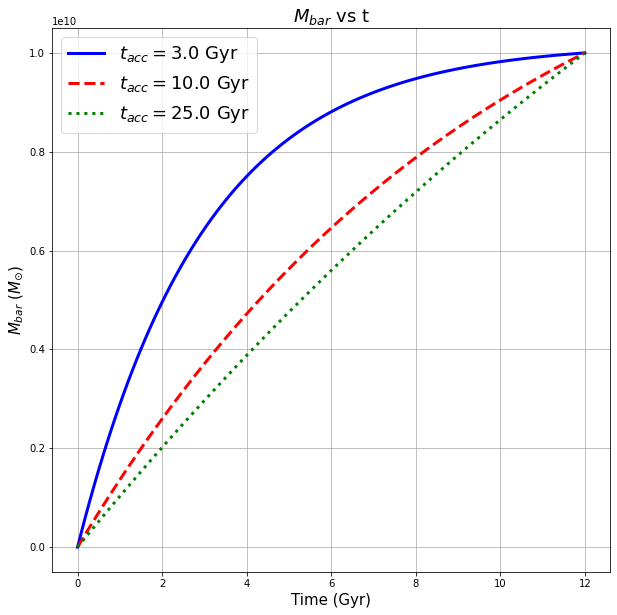

Execution time: 0.8171 seconds


In [4]:
dt=0.1
M_times = np.arange(0,12.1,dt)

def C_def(M_bar, t_acc, t0=12.):
    """Returns the normalization constant by imposing a value of the baryonic mass at a given
    time and accretion timescale. Default time is taken as today, t_0 = 12Gyr."""
    if (t_acc==np.inf):
        return M_bar/t0
    elif (t_acc<0):
        return M_bar/(abs(t_acc)*(np.exp(t0/abs(t_acc))-1))
    else:
        return M_bar/(t_acc*(1-np.exp(-t0/t_acc)))

def M_def(M_bar, t_acc, t=M_times, dt=dt):
    """Returns the baryonic mass predicted from the accreting mass having an exponential form in time."""
    C = C_def(M_bar, t_acc)
    if (t_acc==np.inf):
        return C*t
    elif (t_acc<0):
        return C*abs(t_acc)*(np.exp(t/abs(t_acc))-1)
    else:
        return C*t_acc*(1-np.exp(-t/t_acc))

t_acc = np.array([3.,10.,25.]) #GYr
colors = ['b', 'r', 'g']
styles = ['solid', 'dashed', 'dotted']

M_bar_t0 = 10**10
M_bar_array = np.zeros((len(t_acc),len(M_times)))
for i, t_accr in enumerate(t_acc):
    M_bar_array[i] = M_def(M_bar_t0, t_accr)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
for i, t_accr, col, sty in zip(range(3), t_acc, colors, styles):
    frame.plot(M_times, M_bar_array[i], label = r"$t_{acc} = $"+f"{t_accr} Gyr", color=col, linestyle=sty, lw=3)
frame.set_title(r"$M_{bar}$ vs t", fontsize = 18)
frame.set_xlabel(r"Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$M_{bar}$ $(M_{\odot})$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
pd.DataFrame(M_bar_array.T, columns=['t_acc=3Gyr', 't_acc=10Gyr', 't_acc=25Gyr']).to_csv('data5/M_bar_vs_'+f'{np.log10(M_bar_t0)}'+'.csv')
fig.savefig('graphs6/M_bar vs time (t_acc variation).png')

### a) i) Find $v_{BTFR}$ from $M_{bar}$ (constant in time)

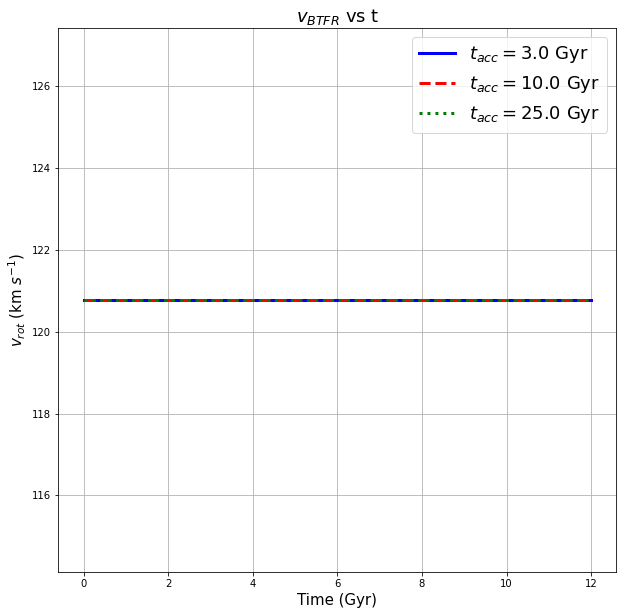

Execution time: 0.4084 seconds


In [5]:
def v_btfr_def(M_bar, Ag=47):
    """Returns the value of the velocity from the baryonic Tully-Fisher relation. The default constant
    value Ag is taken from McGaugh (2012)."""
    return (M_bar/Ag)**0.25

Ag = 47 #M_{\odot} km^{-4} s^{-4}
M_bar_allsame = np.full(M_bar_array.shape, M_bar_t0)
v_btfr_array = v_btfr_def(M_bar_allsame)
#print(v_rot_array)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
for i,t_accr,col,sty in zip(range(3),t_acc, colors, styles):
    frame.plot(M_times, v_btfr_array[i], label = r"$t_{acc} = $"+f"{t_accr} Gyr", color=col, linestyle=sty, lw=3)
frame.set_title(r"$v_{BTFR}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$v_{rot}$ (km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
pd.DataFrame(v_btfr_array.T, columns=['t_acc=3Gyr', 't_acc=10Gyr', 't_acc=25Gyr']).to_csv('data5/v_btfr_vs_t_'+f'{np.log10(M_bar_t0)}'+'.csv')
fig.savefig('graphs6/v_btfr vs time (t_acc variation).png')

### b) Determine $j_{max}$ from $\log(j_{max}(M_{bar})) = 0.73\log(M_{bar})-4.25$

In [6]:
def j_maxer(Mbar):
    """Returns the maximum value of the accreting angular momentum. This is determined empirically, by 
    utilizing the fit found by Mancera-Piña et al. (2021), and setting f_gas = 1. This is because the
    theoretical maximum accreting angular momentum should fall where there is maximum gas, in the outer-most
    regions of the galaxy."""
    return (Mbar**0.73)*10**(-4.25)

j_max = (M_bar_t0**0.73)*10**(-4.25)
print(j_max)

1122.018454301963
Execution time: 0.0015 seconds


### c) Determine $j_{acc}(t)$ from $j_{max}(M_{bar})$

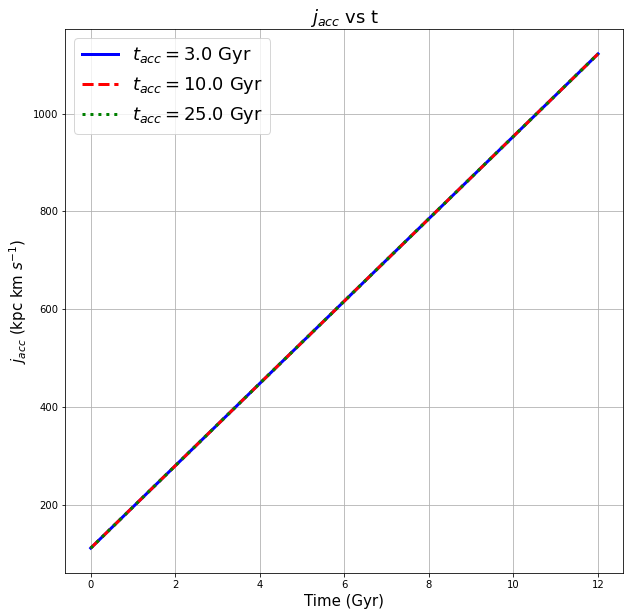

Execution time: 0.3326 seconds


In [7]:
def j_acc_def(j_max, Mbar, t, t0=12, n=1, con=1):
    """Determines the accreting specific angular momentum given j_max, the velocity from the BTFR, at any
    given time. The minimum angular momentum is determined from the mass-scale relation by Wu (2017) and 
    divided by 5. This was chosen as a value that is just high enough to not give errors in later calculations when small
    r_acc gives infinities."""
    #r_acc_min = (10**(0.385*(np.log10(Mbar)-10)+0.281))/5
    j_min = j_max/10.
    return j_min+con*(j_max-j_min)*(t/t0)**n

j_acc_array = j_acc_def(np.full(M_bar_array.shape, j_max), M_bar_allsame, M_times)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
for i,t_accr,col,sty in zip(range(3),t_acc, colors, styles):
    frame.plot(M_times, j_acc_array[i], label = r"$t_{acc} = $"+f"{t_accr} Gyr", color=col, linestyle=sty, lw=3)
frame.set_title(r"$j_{acc}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$j_{acc}$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
pd.DataFrame(j_acc_array.T, columns=['t_acc=3Gyr', 't_acc=10Gyr', 't_acc=25Gyr']).to_csv('data5/j_acc_vs_t_'+f'{np.log10(M_bar_t0)}'+'.csv')
fig.savefig('graphs6/j_acc vs time (t_acc variation).png')

### d) Determine $r_{BTFR}(t)$ from $j_{acc}(t) = 2v_{flat} \left( r_{acc} - \frac{R_v^3 r_{acc}}{(R_v+r_{acc})^3} \right)$

In [8]:
def rv_def(M_bar, kpc=True):
    if kpc:
        return -0.009992663198893158*v_btfr_def(M_bar)+3.145743746418093
    else:
        return -9.992663160737305*v_btfr_def(M_bar)+3145.7437379536254

rv_def(10**10)

1.9388840464991806

Execution time: 0.0029 seconds


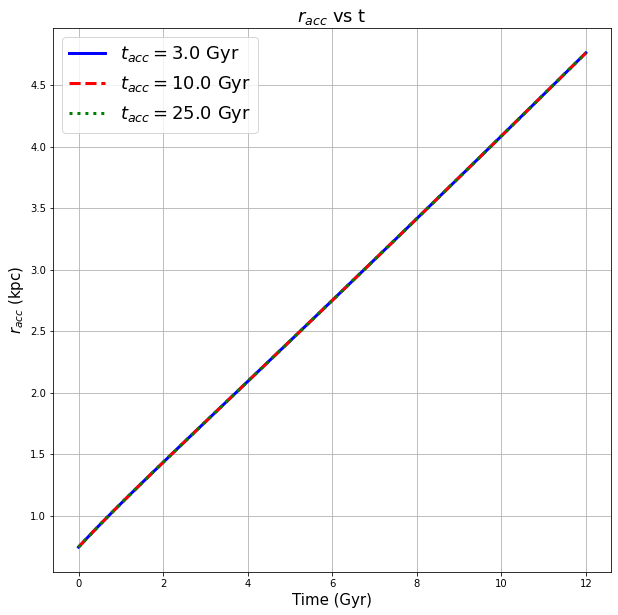

Execution time: 0.3311 seconds


In [9]:
def analytical_r(x, c, y):
    return x - (c**3 * x) / (c + x)**3 - y

def r_btfr_def(M_bar, j_acc, init=1.0):
    
    rv = rv_def(M_bar, kpc=True)
    yer = j_acc / (2*v_btfr_def(M_bar))
    if hasattr(yer, '__len__'):
        r_acc = []
        for i in range(len(j_acc)):
            r_acc.append(optimize.newton(analytical_r, init, args=(rv[i], yer[i])))
        return np.array(r_acc)
    else:
        return optimize.newton(analytical_r, init, args=(rv, yer))

r_btfr_array = np.zeros((len(t_acc),len(M_times)))
for i in range(len(t_acc)):
    r_btfr_array[i,:] = r_btfr_def(M_bar_allsame[i], j_acc_array[i])

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
for i,t_accr,col,sty in zip(range(3),t_acc, colors, styles):
    frame.plot(M_times, r_btfr_array[i], label = r"$t_{acc} = $"+f"{t_accr} Gyr", color=col, linestyle=sty, lw=3)
frame.set_title(r"$r_{acc}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$r_{acc}$ (kpc)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
pd.DataFrame(r_btfr_array.T, columns=['t_acc=3Gyr', 't_acc=10Gyr', 't_acc=25Gyr']).to_csv('data5/r_acc_vs_t_'+f'{np.log10(M_bar_t0)}'+'.csv')
fig.savefig('graphs6/r_acc vs time (t_acc variation).png')

### e) Analytical $j_{bar}$

/var/lib/condor/execute/dir_4989/ipykernel_9828/2673984534.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return dt*np.cumsum(acc_j*M_dot_bar)/bar_mass


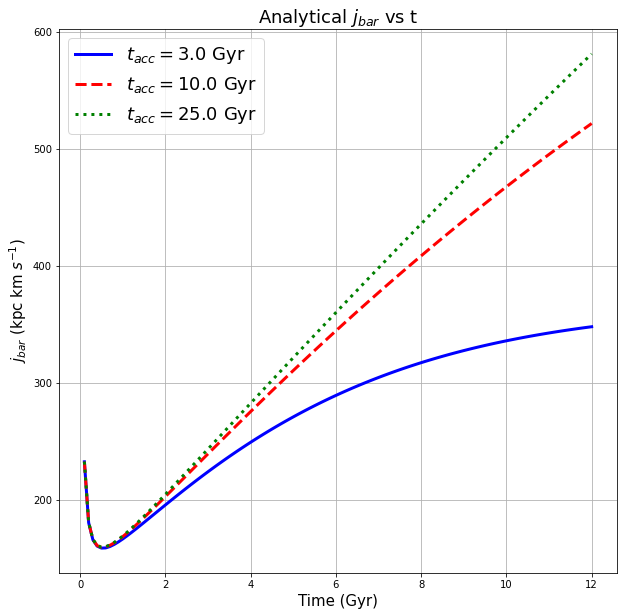

Execution time: 0.3494 seconds


In [10]:
def j_bar_analytical(t, Mbar, t_acc, dt=0.1):
    bar_mass = M_def(Mbar, t_acc, t)
    M_dot_bar = C_def(Mbar, t_acc)*np.exp(-t/t_acc)
    acc_j = j_acc_def(j_maxer(Mbar), Mbar, t)
    return dt*np.cumsum(acc_j*M_dot_bar)/bar_mass

j_bar_array_analytical = np.zeros((len(t_acc),len(M_times)))
for i, t_accr in enumerate(t_acc):
    j_bar_array_analytical[i] = j_bar_analytical(M_times, M_bar_t0, t_accr)
    
fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
for i, t_accr, col, sty in zip(range(3), t_acc, colors, styles):
    frame.plot(M_times, j_bar_array_analytical[i], label = r"$t_{acc} = $"+f"{t_accr} Gyr", color=col, linestyle=sty, lw=3)
frame.set_title(r"Analytical $j_{bar}$ vs t", fontsize = 18)
frame.set_xlabel(r"Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$j_{bar}$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs6/Analytical j_bar vs time (t_acc variation).png')

### f) $\Omega$

In [11]:
def exp_vrot(r, Mbar, kpc=False):
    rv = rv_def(Mbar, kpc=kpc)
    return v_btfr_def(Mbar)*(1-np.exp(-r/rv))

def omega(R, M_bar, rv):
    if hasattr(R, '__len__'):
        omega_list = []
        for r in R:
            if r == 0:
                omega_list.append(v_btfr_def(M_bar)/rv)
            else:
                omega_list.append((v_btfr_def(M_bar)*(1-np.exp(-r/rv)))/r)

        return np.array(omega_list)
    else:
        if R == 0:
            return v_btfr_def(M_bar)/rv
        else:
            return (v_btfr_def(M_bar)*(1-np.exp(-R/rv)))/R

M_times1 = np.arange(0,12.2,dt)
r = np.arange(0,1000*100.1,120)
M_bar_allsame1 = np.full(M_times1.shape, M_bar_t0)
omegas = omega(r, M_bar_t0, rv_def(M_bar_t0, kpc=False))
#print(omegas)

Execution time: 0.0048 seconds


In [12]:
def find_nearest(array, value):
    """
    Finds nearest element in an array with wanted value
    
    Inputs:
    array(np.array): array to extract closest element to wanted value
    value(int): wanted value to find closest element to
    
    Returns:
    array[idx](np.array): indexed array with index of closest value
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

index_r1 = np.argwhere(r == find_nearest(r, 25000.))[0][0]
index_r2 = np.argwhere(r == find_nearest(r, 50000.))[0][0]
index_r3 = np.argwhere(r == find_nearest(r, 75000.))[0][0]
index_r4 = np.argwhere(r == find_nearest(r, 100000.))[0][0]
index_t1 = np.argwhere(M_times1 == 3.)[0][0]
index_t2 = np.argwhere(M_times1 == 6.)[0][0]
index_t3 = np.argwhere(M_times1 == 9.)[0][0]
index_t4 = np.argwhere(M_times1 == 12.)[0][0]

Execution time: 0.0022 seconds


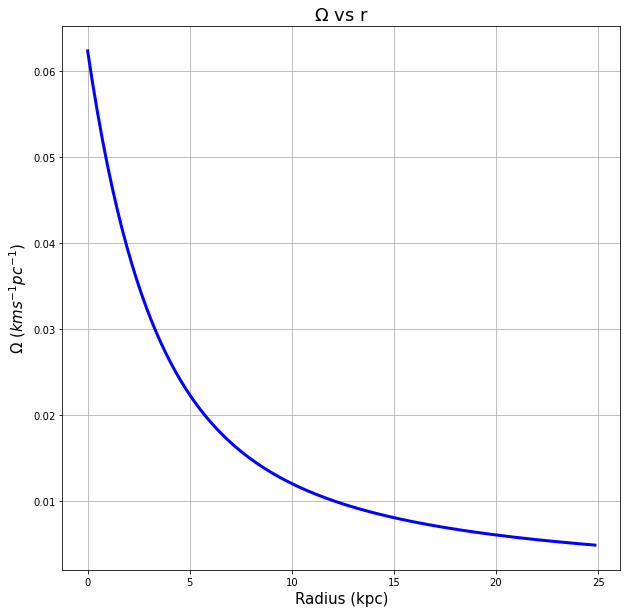

Execution time: 0.1873 seconds


In [13]:
fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(r[:index_r1]/1000, omegas[:index_r1], color='blue', lw=3)
frame.set_title(r"$\Omega$ vs r", fontsize = 18)
frame.set_xlabel(r"Radius (kpc)", fontsize = 15)
frame.set_ylabel(r"$\Omega$ $(kms^{-1}pc^{-1})$", fontsize = 15)
frame.grid()
show()
fig.savefig('graphs6/Omega vs r.png')

## 2) Solve $\frac{\mathrm{d} \Sigma_{gas}(t,R)}{\mathrm{d} t} = \frac{C}{2 \pi r_{acc}(t)^2} e^{-\frac{t}{t_{acc}}} e^{-\frac{R}{r_{acc}(t)}} - A(1-\Re) \Sigma_{gas}^N(t,R)$ given $r_{acc}(t)$ from (1)

In [14]:
def SFL(sigma, sfl_type, R, Mbar):
    Rf = 0.3
    if sfl_type == "old_ksl":
        N = 1.4
        A = 0.1625
        return (1-Rf)*A*(sigma**N)
    elif sfl_type == "new_ksl":
        A_ksl = 10**-2.81
        N_ksl = 3.83
        return (1-Rf)*A_ksl*(sigma**N_ksl)
    elif sfl_type == "boissier":
        A_boissier = 10**-3.45
        N_boissier = 2.79
        return (1-Rf)*A_boissier*(sigma**N_boissier)*omega(R, Mbar, rv_def(Mbar, kpc=False))*1022 #factor to convert km/s/pc to 1/Gyr

Execution time: 0.0013 seconds


In [15]:
Rf = 0.3 #return factor
N = 1.4
A = 0.1625

def RungeKutta(x, y, dx, dydx):
    """
    Runge-Kutta method to solve differential equations.
    
    x = (initial) x values
    y = (initial) y values
    dx = step size
    dydx = differential equation
    """
    # Calculate slopes
    k1 = dx*dydx(x, y)
    k2 = dx*dydx(x+dx/2., y+k1/2.)
    k3 = dx*dydx(x+dx/2., y+k2/2.)
    k4 = dx*dydx(x+dx, y+k3)
    
    # Calculate new x and y
    y = y + (1./6.)*(k1+2*k2+2*k3+k4)
    x = x + dx
    
    return x, y

def Sigma_definer(r, t_acc, M_bar, SFL_type, n=1, con=1, how=2):
    """
    This fucntion defines the gas surface density 2D array, 
    where the columns are for varying radius, and the rows are for varying time.
    As input it takes:
    r = the radius 1D array, giving the max and min values of the radius of a galaxy
    r_acc = radial scale length of accretion
    t_acc = accretion timescale
    C = Gives value of the desired baryonic mass at a time t (usually t_0)
    """
    M_sigma = np.zeros(len(r)*(len(M_times)+1)).reshape(len(r),len(M_times)+1)
    #time_matrix = np.zeros(len(r)*(len(M_times)+1)).reshape(len(r),len(M_times)+1)
    C = C_def(M_bar, t_acc)
    jmax = (M_bar**0.73)*10**(-4.25)
    
    #r_acc = 1000*r_btfr_def(M_bar, j_acc_def(jmax, M_bar, np.arange(0,12.2,dt), n=n, con=con))
    
    for i, r_value in enumerate(r):
        def dydx(t, S):
            r_acc = 1000*r_btfr_def(M_bar, j_acc_def(jmax, M_bar, t, n=n, con=con))
            #print(S)
            return (C/(2*np.pi*(r_acc**2)))*np.exp(-t/t_acc)*np.exp(-r_value/r_acc)-SFL(S, SFL_type, r_value, M_bar)
        
        if (how == 1):
            x0 = 0.
            y0 = 0.
            dx = 0.1
            x_end = 12.
            row = np.zeros(len(M_times)+1)
            y = y0
            x = x0
            row[0] = y
            j=1
            while (x <= x_end):
                x, y = RungeKutta(x, y, dx, dydx)
                #print("break")
                row[j] = y
                #time_row[j] = x
                j+=1
        
        else:
            x0 = 0.
            y0 = 0.
            dx = 0.1
            x_end = 12.2
            row = spint.solve_ivp(dydx, [x0, x_end], [y0], t_eval=M_times1, atol=1e-9, rtol=1e-9).y

        #print(row)
        M_sigma[i,:] = row
        #time_matrix[i,:] = time_row
    return M_sigma


Execution time: 0.0071 seconds


In [16]:
Sigma_gas_old_ksl1 = Sigma_definer(r, t_acc[0], M_bar_t0, SFL_type="old_ksl")
print(Sigma_gas_old_ksl1)
Sigma_gas_old_ksl2 = Sigma_definer(r, t_acc[1], M_bar_t0, SFL_type="old_ksl")
Sigma_gas_old_ksl3 = Sigma_definer(r, t_acc[2], M_bar_t0, SFL_type="old_ksl")
np.savetxt('data5/Sigma_gas_old_ksl1_'+f'{np.log10(M_bar_t0)}'+'.txt', Sigma_gas_old_ksl1)
np.savetxt('data5/Sigma_gas_old_ksl2_'+f'{np.log10(M_bar_t0)}'+'.txt', Sigma_gas_old_ksl2)
np.savetxt('data5/Sigma_gas_old_ksl3_'+f'{np.log10(M_bar_t0)}'+'.txt', Sigma_gas_old_ksl3)

Sigma_gas_new_ksl1 = Sigma_definer(r, t_acc[0], M_bar_t0, SFL_type="new_ksl")
print(Sigma_gas_new_ksl1)
Sigma_gas_new_ksl2 = Sigma_definer(r, t_acc[1], M_bar_t0, SFL_type="new_ksl")
Sigma_gas_new_ksl3 = Sigma_definer(r, t_acc[2], M_bar_t0, SFL_type="new_ksl")
np.savetxt('data5/Sigma_gas_new_ksl1_'+f'{np.log10(M_bar_t0)}'+'.txt', Sigma_gas_new_ksl1)
np.savetxt('data5/Sigma_gas_new_ksl2_'+f'{np.log10(M_bar_t0)}'+'.txt', Sigma_gas_new_ksl2)
np.savetxt('data5/Sigma_gas_new_ksl3_'+f'{np.log10(M_bar_t0)}'+'.txt', Sigma_gas_new_ksl3)

Sigma_gas_boissier1 = Sigma_definer(r, t_acc[0], M_bar_t0, SFL_type="boissier")
print(Sigma_gas_boissier1)
Sigma_gas_boissier2 = Sigma_definer(r, t_acc[1], M_bar_t0, SFL_type="boissier")
Sigma_gas_boissier3 = Sigma_definer(r, t_acc[2], M_bar_t0, SFL_type="boissier")
np.savetxt('data5/Sigma_gas_boissier1_'+f'{np.log10(M_bar_t0)}'+'.txt', Sigma_gas_boissier1)
np.savetxt('data5/Sigma_gas_boissier2_'+f'{np.log10(M_bar_t0)}'+'.txt', Sigma_gas_boissier2)
np.savetxt('data5/Sigma_gas_boissier3_'+f'{np.log10(M_bar_t0)}'+'.txt', Sigma_gas_boissier3)

/var/lib/condor/execute/dir_4989/ipykernel_9828/2322890892.py:6: RuntimeWarning: invalid value encountered in power
  return (1-Rf)*A*(sigma**N)


[[0.00000000e+00 8.85278234e+01 1.58895808e+02 ... 9.38778174e+00
  9.17512792e+00 8.96849758e+00]
 [0.00000000e+00 7.57870776e+01 1.36872121e+02 ... 9.23010730e+00
  9.02234218e+00 8.82042147e+00]
 [0.00000000e+00 6.48730963e+01 1.17870817e+02 ... 9.07375750e+00
  8.87081874e+00 8.67354835e+00]
 ...
 [0.00000000e+00 5.42704660e-55 1.51927683e-52 ... 2.53256801e-10
  2.85746511e-10 3.21672175e-10]
 [0.00000000e+00 4.65001564e-55 1.31046137e-52 ... 2.46728036e-10
  2.78331127e-10 3.13311249e-10]
 [0.00000000e+00 3.98424465e-55 1.13034765e-52 ... 2.40188253e-10
  2.71002679e-10 3.05115790e-10]]


/var/lib/condor/execute/dir_4989/ipykernel_9828/2322890892.py:10: RuntimeWarning: invalid value encountered in power
  return (1-Rf)*A_ksl*(sigma**N_ksl)


[[0.00000000e+00 3.47426938e+01 3.36518927e+01 ... 5.86580310e+00
  5.81702635e+00 5.76910098e+00]
 [0.00000000e+00 3.33590748e+01 3.23948974e+01 ... 5.83745774e+00
  5.78927163e+00 5.74192202e+00]
 [0.00000000e+00 3.19935497e+01 3.11847335e+01 ... 5.80928975e+00
  5.76168860e+00 5.71490928e+00]
 ...
 [0.00000000e+00 5.42704660e-55 1.51927683e-52 ... 2.53258908e-10
  2.85749081e-10 3.21675291e-10]
 [0.00000000e+00 4.65001564e-55 1.31046137e-52 ... 2.46730161e-10
  2.78333697e-10 3.13314344e-10]
 [0.00000000e+00 3.98424465e-55 1.13034765e-52 ... 2.40190297e-10
  2.71005152e-10 3.05118768e-10]]


/var/lib/condor/execute/dir_4989/ipykernel_9828/2322890892.py:14: RuntimeWarning: invalid value encountered in power
  return (1-Rf)*A_boissier*(sigma**N_boissier)*omega(R, Mbar, rv_def(Mbar, kpc=False))*1022 #factor to convert km/s/pc to 1/Gyr


[[0.00000000e+00 4.89692967e+01 4.79740220e+01 ... 4.38528711e+00
  4.33385645e+00 4.28344827e+00]
 [0.00000000e+00 4.61168696e+01 4.60282485e+01 ... 4.41262890e+00
  4.36135069e+00 4.31108575e+00]
 [0.00000000e+00 4.31001188e+01 4.41328276e+01 ... 4.43970997e+00
  4.38859093e+00 4.33847578e+00]
 ...
 [0.00000000e+00 5.42704660e-55 1.51927683e-52 ... 2.53258908e-10
  2.85749081e-10 3.21675291e-10]
 [0.00000000e+00 4.65001564e-55 1.31046137e-52 ... 2.46730161e-10
  2.78333697e-10 3.13314344e-10]
 [0.00000000e+00 3.98424465e-55 1.13034765e-52 ... 2.40190297e-10
  2.71005152e-10 3.05118768e-10]]
Execution time: 401.9765 seconds


In [17]:
test = Sigma_definer(r, t_acc[0], M_bar_t0, SFL_type="old_ksl", how=1)
print(test[0])

57.985578775405884
[  0.          88.50885665 158.87728465 212.65538257 252.3034151
 280.32488905 298.9949829  310.2724799  315.79083729 316.88398647
 314.62530393 309.86905692 303.28925595 295.41382247 286.65352807
 277.32592343 267.67480801 257.88589567 248.09932082 238.4195665
 228.92331418 219.66563214 210.68484361 202.00634999 193.6456294
 185.61058571 177.90338639 170.52189875 163.46081031 156.71250129
 150.26772212 144.11611809 138.24663364 132.64782252 127.30808379
 122.21583988 117.35966916 112.7284031  108.31119561 104.09757097
 100.07745497  96.24119332  92.57956011  89.08375893  85.74541829
  82.55658299  79.50970249  76.5976172   73.81354337  71.15105715
  68.60407825  66.16685341  63.8339401   61.60019041  59.46073545
  57.41097027  55.44653929  53.56332245  51.75742196  50.02514965
  48.36301506  46.76771411  45.23611839  43.76526507  42.35234738
  40.99470563  39.68981878  38.43529648  37.2288716   36.06839324
  34.95182008  33.8772142   32.84273527  31.84663502  30.887

### Testing the time

t0 = time.time()
Sigma_definer(r, t_acc[0], M_bar_t0, SFL_type="old_ksl", how=1)
t1 = time.time()
print(t1-t0)

print(Sigma_definer(r, t_acc[0], M_bar_t0, SFL_type="old_ksl", how=1))

t0 = time.time()
Sigma_definer(r, t_acc[0], M_bar_t0, SFL_type="old_ksl", how=2)
t1 = time.time()
print(t1-t0)

print(Sigma_definer(r, t_acc[0], M_bar_t0, SFL_type="old_ksl", how=2))

### $log(\dot{\Sigma}_{acc})$ vs r for different t and $t_{acc}$

In [18]:
def Sigma_acc_def(R, t, t_acc, M_bar):
    """
    Defines Sigma_acc rate (dotted), the accretion rate surface density, as a function of r and t
    
    Inputs:
    R(np.array): Radius array
    t(np.array): Time array
    t_acc(float): Accretion timescale value
    M_bar(float): Total baryonic mass value
    
    Returns:
    Sigma_acc_dot(np.array): 2D array of the accretion rate SD, with t in the x-axis and r in the y-axis
    """
    C = M_bar/(t_acc*(1-np.exp(-12./t_acc)))
    jmax = (M_bar**0.73)*10**(-4.25)
    r_acc = np.zeros(len(t))
    for j,ti in enumerate(t):
        r_acc[j] = 1000*r_btfr_def(M_bar, j_acc_def(jmax, M_bar, ti))
        #if (r_acc[j] == 0):
        #    r_acc[j] = 100.
    Sigma_acc_dot = np.zeros((len(R),len(t)))
    for i,r_value in enumerate(R):
        Sigma_acc_dot[i,:] = ((C)/(2*np.pi*r_acc**2))*np.exp((-t)/(t_acc))*np.exp((-r_value)/(r_acc))
    return Sigma_acc_dot

M_sigma_acc_dot1 = Sigma_acc_def(r, M_times1, t_acc[0], M_bar_t0)
M_sigma_acc_dot2 = Sigma_acc_def(r, M_times1, t_acc[1], M_bar_t0)
M_sigma_acc_dot3 = Sigma_acc_def(r, M_times1, t_acc[2], M_bar_t0)
np.savetxt('data5/M_sigma_acc1_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sigma_acc_dot1)
np.savetxt('data5/M_sigma_acc2_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sigma_acc_dot2)
np.savetxt('data5/M_sigma_acc3_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sigma_acc_dot3)
print(M_sigma_acc_dot1)

[[9.72591246e+02 8.54028085e+02 7.54152911e+02 ... 4.58067659e-01
  4.36762343e-01 4.16488433e-01]
 [8.27972400e+02 7.32582410e+02 6.51340331e+02 ... 4.46584494e-01
  4.25890272e-01 4.06193449e-01]
 [7.04857563e+02 6.28406721e+02 5.62544041e+02 ... 4.35389198e-01
  4.15288834e-01 3.96152942e-01]
 ...
 [6.59279242e-56 3.21542378e-53 8.30730304e-51 ... 3.07118506e-10
  3.40371605e-10 3.76476779e-10]
 [5.61248128e-56 2.75817967e-53 7.17478038e-51 ... 2.99419442e-10
  3.31898933e-10 3.67170824e-10]
 [4.77793689e-56 2.36595722e-53 6.19665290e-51 ... 2.91913384e-10
  3.23637166e-10 3.58094899e-10]]
Execution time: 0.3786 seconds


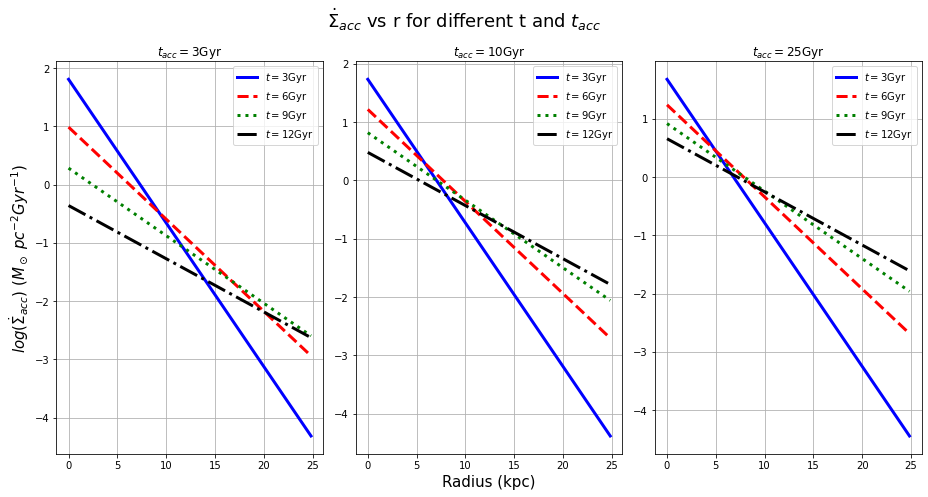

Execution time: 1.0127 seconds


In [19]:
M_sigma_accs = np.array([M_sigma_acc_dot1, M_sigma_acc_dot2, M_sigma_acc_dot3])

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$\dot{\Sigma}_{acc}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$log(\dot{\Sigma}_{acc})$ $(M_\odot\ pc^{-2} Gyr^{-1})$", fontsize = 15)

for i, M, t_accr in zip(range(3), M_sigma_accs, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs6/dotSigma_acc vs r (t_acc variation).png')

### $log(\Sigma_{gas})$ vs r for different t and $t_{acc}$

In [44]:
np.log10(Sigma_gas_old_ksl1)

/var/lib/condor/execute/dir_4989/ipykernel_9828/373890284.py:1: RuntimeWarning: divide by zero encountered in log10
  np.log10(Sigma_gas_old_ksl1)


array([[        -inf,   1.94707979,   2.20111244, ...,   0.97256298,
          0.96261213,   0.9527197 ],
       [        -inf,   1.87959516,   2.136315  , ...,   0.96520675,
          0.95531929,   0.94548934],
       [        -inf,   1.81206463,   2.07140629, ...,   0.95778717,
          0.94796371,   0.9381968 ],
       ...,
       [        -inf, -54.26543645, -51.81836309, ...,  -9.59643888,
         -9.54401906,  -9.4925865 ],
       [        -inf, -54.33254559, -51.88257578, ...,  -9.6077815 ,
         -9.55543822,  -9.50402401],
       [        -inf, -54.399654  , -51.94678796, ...,  -9.61944824,
         -9.56702642,  -9.51553532]])

Execution time: 0.1990 seconds


warnings.filterwarnings('ignore')

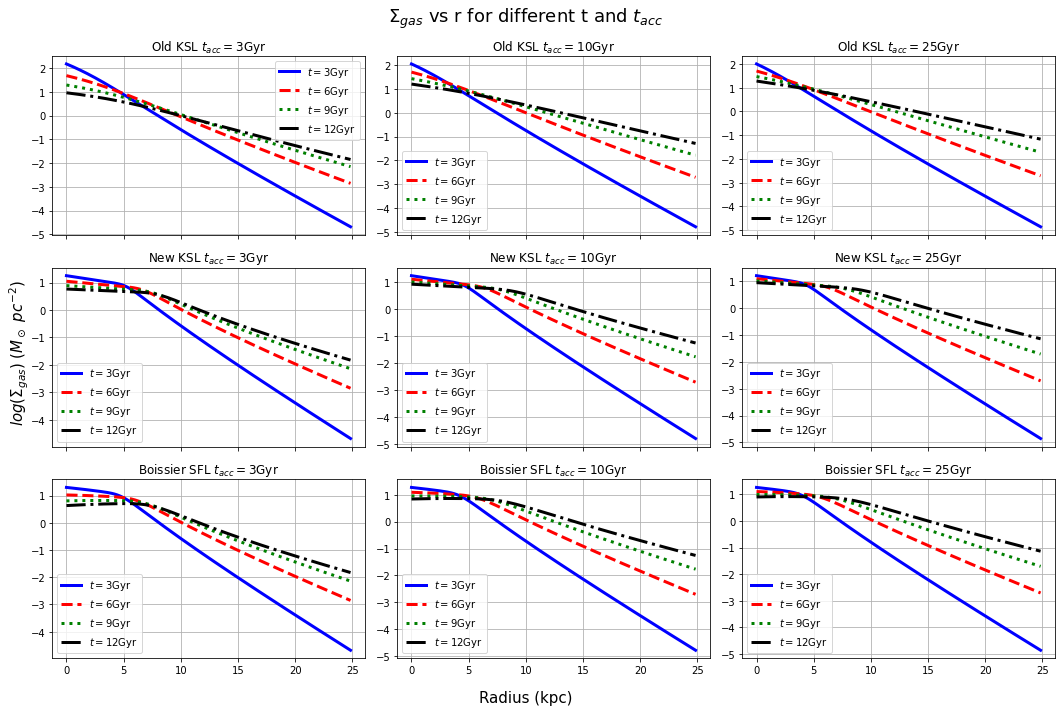

Execution time: 1.7359 seconds


In [20]:
Sigma_gas_old_ksl = np.array([Sigma_gas_old_ksl1, Sigma_gas_old_ksl2, Sigma_gas_old_ksl3])
Sigma_gas_new_ksl = np.array([Sigma_gas_new_ksl1, Sigma_gas_new_ksl2, Sigma_gas_new_ksl3])
Sigma_gas_boissier = np.array([Sigma_gas_boissier1, Sigma_gas_boissier2, Sigma_gas_boissier3])

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(15, 10))

# Set the labels and titles of the subplots
fig.suptitle(r"$\Sigma_{gas}$ vs r for different t and $t_{acc}$", fontsize = 18)
fig.supxlabel("Radius (kpc)", fontsize = 15)
fig.supylabel(r"$log(\Sigma_{gas})$ $(M_\odot\ pc^{-2})$", fontsize = 15)
    
for i, M1, M2, M3, t_accr in zip(range(3), Sigma_gas_old_ksl, Sigma_gas_new_ksl, Sigma_gas_boissier, t_acc):
    axes[0,i].plot(r[:index_r1]/1000, np.log10(M1[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[0,i].plot(r[:index_r1]/1000, np.log10(M1[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[0,i].plot(r[:index_r1]/1000, np.log10(M1[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[0,i].plot(r[:index_r1]/1000, np.log10(M1[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[0,i].set_title(r"Old KSL $t_{acc}=$"+f"{t_accr:.0f}Gyr")
    
    axes[1,i].plot(r[:index_r1]/1000, np.log10(M2[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[1,i].plot(r[:index_r1]/1000, np.log10(M2[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[1,i].plot(r[:index_r1]/1000, np.log10(M2[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[1,i].plot(r[:index_r1]/1000, np.log10(M2[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[1,i].set_title(r"New KSL $t_{acc}=$"+f"{t_accr:.0f}Gyr")
    
    axes[2,i].plot(r[:index_r1]/1000, np.log10(M3[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[2,i].plot(r[:index_r1]/1000, np.log10(M3[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[2,i].plot(r[:index_r1]/1000, np.log10(M3[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[2,i].plot(r[:index_r1]/1000, np.log10(M3[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[2,i].set_title(r"Boissier SFL $t_{acc}=$"+f"{t_accr:.0f}Gyr")
    
    axes[0,i].legend()
    axes[1,i].legend()
    axes[2,i].legend()
    
# Add grid lines to each subplot and adjust layout
for axe in axes:
    for ax in axe:
        ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs6/Sigma_gas vs r (t_acc variation).png')

### $log(\Sigma_{SFR})$ vs r for different t and $t_{acc}$

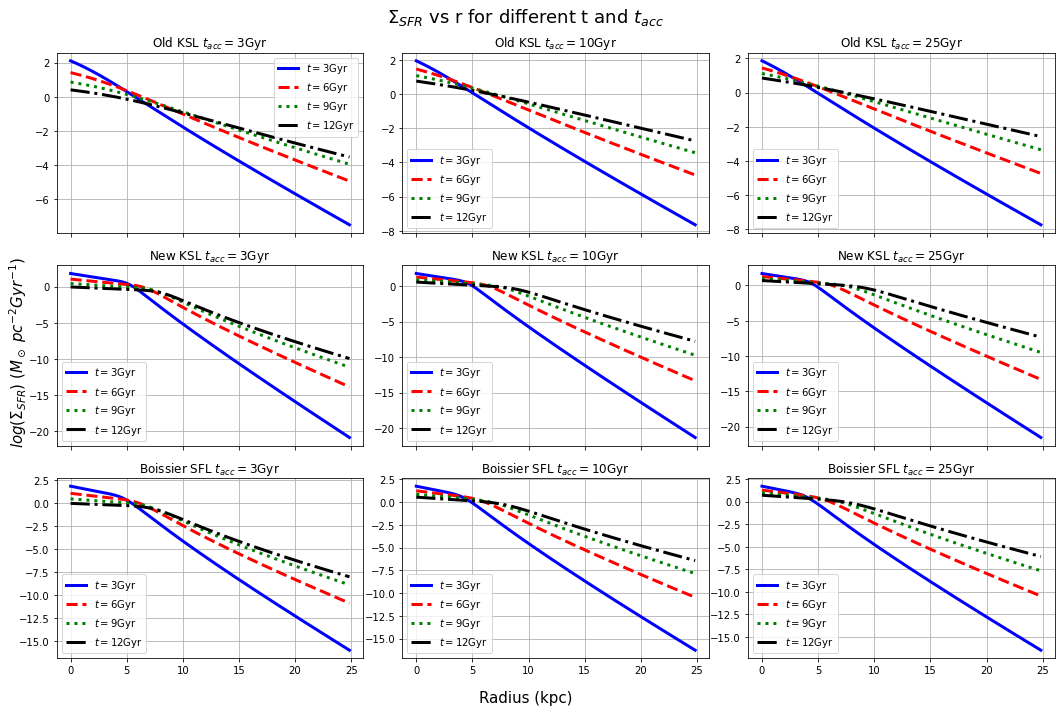

Execution time: 1.6769 seconds


In [21]:
M_sfrs_boissier = np.array([(SFL(sigma=Sigma_gas_boissier[i], sfl_type="boissier", R=r, Mbar=M_bar_allsame1)) for i in range(len(t_acc))])
M_sfrs_ksl = SFL(sigma=Sigma_gas_new_ksl, sfl_type="new_ksl", R=r, Mbar=M_bar_t0)
M_sfrs = SFL(sigma=Sigma_gas_old_ksl, sfl_type="old_ksl", R=r, Mbar=M_bar_t0)
#print(M_sfrs_boissier)
#np.savetxt('data5/M_sfr1_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sfrs[0])
#np.savetxt('data5/M_sfr2_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sfrs[1])
#np.savetxt('data5/M_sfr3_'+f'{np.log10(M_bar_t0)}'+'.txt', M_sfrs[2])

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(15, 10), facecolor='w')

# Set the labels and titles of the subplots
fig.suptitle(r"$\Sigma_{SFR}$ vs r for different t and $t_{acc}$", fontsize = 18)
fig.supxlabel("Radius (kpc)", fontsize = 15)
fig.supylabel(r"$log(\Sigma_{SFR})$ $(M_\odot\ pc^{-2} Gyr^{-1})$", fontsize = 15)

for i, M1, M2, M3, t_accr in zip(range(3), M_sfrs, M_sfrs_ksl, M_sfrs_boissier, t_acc):
    axes[0,i].plot(r[:index_r1]/1000, np.log10(M1[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[0,i].plot(r[:index_r1]/1000, np.log10(M1[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[0,i].plot(r[:index_r1]/1000, np.log10(M1[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[0,i].plot(r[:index_r1]/1000, np.log10(M1[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[0,i].set_title(r"Old KSL $t_{acc}=$"+f"{t_accr:.0f}Gyr")
    
    axes[1,i].plot(r[:index_r1]/1000, np.log10(M2[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[1,i].plot(r[:index_r1]/1000, np.log10(M2[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[1,i].plot(r[:index_r1]/1000, np.log10(M2[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[1,i].plot(r[:index_r1]/1000, np.log10(M2[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[1,i].set_title(r"New KSL $t_{acc}=$"+f"{t_accr:.0f}Gyr")
    
    axes[2,i].plot(r[:index_r1]/1000, np.log10(M3[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[2,i].plot(r[:index_r1]/1000, np.log10(M3[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[2,i].plot(r[:index_r1]/1000, np.log10(M3[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[2,i].plot(r[:index_r1]/1000, np.log10(M3[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[2,i].set_title(r"Boissier SFL $t_{acc}=$"+f"{t_accr:.0f}Gyr")
    
    axes[0,i].legend()
    axes[1,i].legend()
    axes[2,i].legend()
    
# Add grid lines to each subplot and adjust layout
for axe in axes:
    for ax in axe:
        ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs6/Sigma_sfr vs r (t_acc variation).png')

In [22]:
SFL_type = "new_ksl"

Execution time: 0.0004 seconds


### $log(\Sigma_{\star})$ vs r for different t and $t_{acc}$

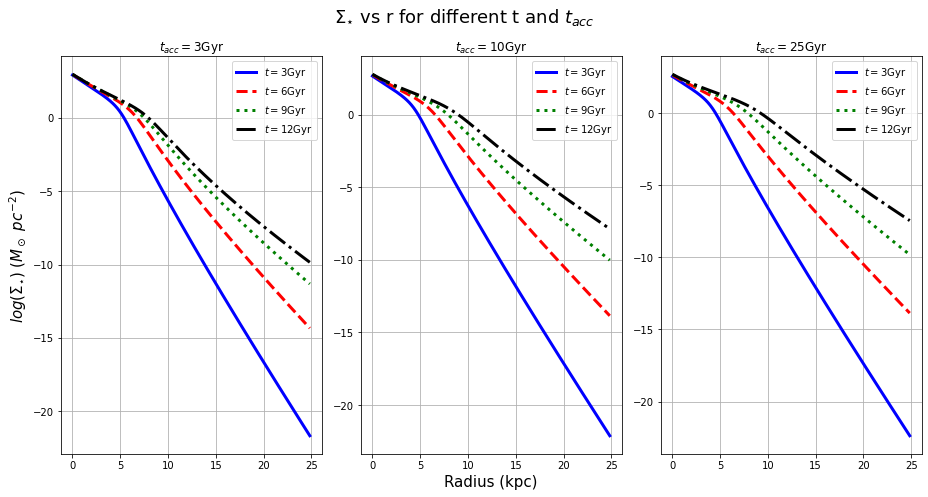

Execution time: 0.9171 seconds


In [23]:
if SFL_type == "old_ksl":
    M_star1 = dt*np.cumsum(M_sfrs[0], axis=1)
    M_star2 = dt*np.cumsum(M_sfrs[1], axis=1)
    M_star3 = dt*np.cumsum(M_sfrs[2], axis=1)
elif SFL_type == "new_ksl":
    M_star1 = dt*np.cumsum(M_sfrs_ksl[0], axis=1)
    M_star2 = dt*np.cumsum(M_sfrs_ksl[1], axis=1)
    M_star3 = dt*np.cumsum(M_sfrs_ksl[2], axis=1)
elif SFL_type == "boissier":
    M_star1 = dt*np.cumsum(M_sfrs_boissier[0], axis=1)
    M_star2 = dt*np.cumsum(M_sfrs_boissier[1], axis=1)
    M_star3 = dt*np.cumsum(M_sfrs_boissier[2], axis=1)

M_stars = np.array([M_star1, M_star2, M_star3])
np.savetxt('data5/M_star1_'+f'{np.log10(M_bar_t0)}'+'.txt', M_star1)
np.savetxt('data5/M_star2_'+f'{np.log10(M_bar_t0)}'+'.txt', M_star2)
np.savetxt('data5/M_star3_'+f'{np.log10(M_bar_t0)}'+'.txt', M_star3)

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$\Sigma_{\star}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$log(\Sigma_{\star})$ $(M_\odot\ pc^{-2})$", fontsize = 15)

for i, M, t_accr in zip(range(3), M_stars, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs6/Sigma_star vs r (t_acc variation).png')

### $log(\Sigma_{bar})$ vs r for different t and $t_{acc}$

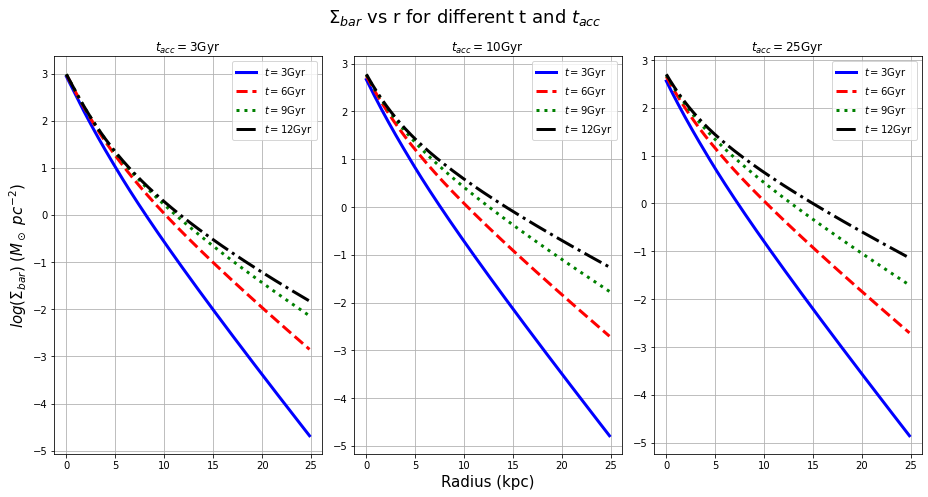

Execution time: 2.5609 seconds


In [24]:
if SFL_type == "old_ksl":
    M_bar1 = np.array([np.sum(x) for x in zip(Sigma_gas_old_ksl1.ravel(), M_star1.ravel())]).reshape(Sigma_gas_old_ksl1.shape)
    M_bar2 = np.array([np.sum(x) for x in zip(Sigma_gas_old_ksl2.ravel(), M_star2.ravel())]).reshape(Sigma_gas_old_ksl2.shape)
    M_bar3 = np.array([np.sum(x) for x in zip(Sigma_gas_old_ksl3.ravel(), M_star3.ravel())]).reshape(Sigma_gas_old_ksl3.shape)
elif SFL_type == "new_ksl":
    M_bar1 = np.array([np.sum(x) for x in zip(Sigma_gas_new_ksl1.ravel(), M_star1.ravel())]).reshape(Sigma_gas_new_ksl1.shape)
    M_bar2 = np.array([np.sum(x) for x in zip(Sigma_gas_new_ksl2.ravel(), M_star2.ravel())]).reshape(Sigma_gas_new_ksl2.shape)
    M_bar3 = np.array([np.sum(x) for x in zip(Sigma_gas_new_ksl3.ravel(), M_star3.ravel())]).reshape(Sigma_gas_new_ksl3.shape)
elif SFL_type == "boissier":
    M_bar1 = np.array([np.sum(x) for x in zip(Sigma_gas_boissier1.ravel(), M_star1.ravel())]).reshape(Sigma_gas_boissier1.shape)
    M_bar2 = np.array([np.sum(x) for x in zip(Sigma_gas_boissier2.ravel(), M_star2.ravel())]).reshape(Sigma_gas_boissier2.shape)
    M_bar3 = np.array([np.sum(x) for x in zip(Sigma_gas_boissier3.ravel(), M_star3.ravel())]).reshape(Sigma_gas_boissier3.shape)

M_bars = np.array([M_bar1, M_bar2, M_bar3])
#print(M_bar1)
np.savetxt('data5/M_bar1_'+f'{np.log10(M_bar_t0)}'+'.txt', M_bar1)
np.savetxt('data5/M_bar2_'+f'{np.log10(M_bar_t0)}'+'.txt', M_bar2)
np.savetxt('data5/M_bar3_'+f'{np.log10(M_bar_t0)}'+'.txt', M_bar3)

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$\Sigma_{bar}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$log(\Sigma_{bar})$ $(M_\odot\ pc^{-2})$", fontsize = 15)

for i, M, t_accr in zip(range(3), M_bars, t_acc):
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t1])[:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t2])[:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t3])[:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, np.log10(M[:,index_t4])[:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs6/Sigma_bar vs r (t_acc variation).png')

warnings.filterwarnings('default')

## $f_{gas}$ vs r

/var/lib/condor/execute/dir_4989/ipykernel_9828/1137573531.py:6: RuntimeWarning: invalid value encountered in true_divide
  f_gas1 = np.divide(Sigma_gas_new_ksl1, M_bar1)
/var/lib/condor/execute/dir_4989/ipykernel_9828/1137573531.py:7: RuntimeWarning: invalid value encountered in true_divide
  f_gas2 = np.divide(Sigma_gas_new_ksl2, M_bar2)
/var/lib/condor/execute/dir_4989/ipykernel_9828/1137573531.py:8: RuntimeWarning: invalid value encountered in true_divide
  f_gas3 = np.divide(Sigma_gas_new_ksl3, M_bar3)


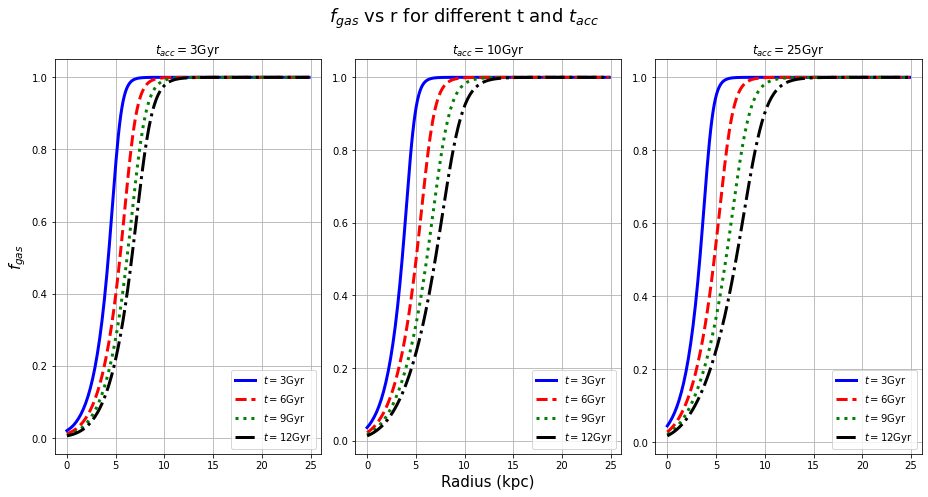

Execution time: 0.8419 seconds


In [25]:
if SFL_type == "old_ksl":
    f_gas1 = np.divide(Sigma_gas_old_ksl1, M_bar1)
    f_gas2 = np.divide(Sigma_gas_old_ksl2, M_bar2)
    f_gas3 = np.divide(Sigma_gas_old_ksl3, M_bar3)
elif SFL_type == "new_ksl":
    f_gas1 = np.divide(Sigma_gas_new_ksl1, M_bar1)
    f_gas2 = np.divide(Sigma_gas_new_ksl2, M_bar2)
    f_gas3 = np.divide(Sigma_gas_new_ksl3, M_bar3)
elif SFL_type == "boissier":
    f_gas1 = np.divide(Sigma_gas_boissier1, M_bar1)
    f_gas2 = np.divide(Sigma_gas_boissier2, M_bar2)
    f_gas3 = np.divide(Sigma_gas_boissier3, M_bar3)

f_gass = np.array([f_gas1, f_gas2, f_gas3])
np.savetxt('data5/f_gas1_'+f'{np.log10(M_bar_t0)}'+'.txt', f_gas1)
np.savetxt('data5/f_gas2_'+f'{np.log10(M_bar_t0)}'+'.txt', f_gas2)
np.savetxt('data5/f_gas3_'+f'{np.log10(M_bar_t0)}'+'.txt', f_gas3)

# Create a figure with three subplots
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey="col", figsize=(13, 7))

# Set the labels and titles of the subplots
f1 = axes[0]
f2 = axes[1]
f3 = axes[2]
fig.suptitle(r"$f_{gas}$ vs r for different t and $t_{acc}$", fontsize = 18)
f2.set_xlabel("Radius (kpc)", fontsize = 15)
f1.set_ylabel(r"$f_{gas}$", fontsize = 15)

for i, f_gas, t_accr in zip(range(3), f_gass, t_acc):
    axes[i].plot(r[:index_r1]/1000, f_gas[:,index_t1][:index_r1], label=r"$t = 3$Gyr", color="blue", lw=3)
    axes[i].plot(r[:index_r1]/1000, f_gas[:,index_t2][:index_r1], label=r"$t = 6$Gyr", linestyle="dashed", color="red", lw=3)
    axes[i].plot(r[:index_r1]/1000, f_gas[:,index_t3][:index_r1], label=r"$t = 9$Gyr", linestyle="dotted", color="green", lw=3)
    axes[i].plot(r[:index_r1]/1000, f_gas[:,index_t4][:index_r1], label=r"$t = 12$Gyr", linestyle="dashdot", color="black", lw=3)
    axes[i].set_title(r"$t_{acc}=$"+f"{t_accr:.0f}Gyr")
    axes[i].legend()
    
# Add grid lines to each subplot and adjust layout
for ax in axes:
    ax.grid(True)

plt.tight_layout()
show()
fig.savefig('graphs6/f_gas vs r (t_acc variation).png')

## $M_{gas}$ vs t

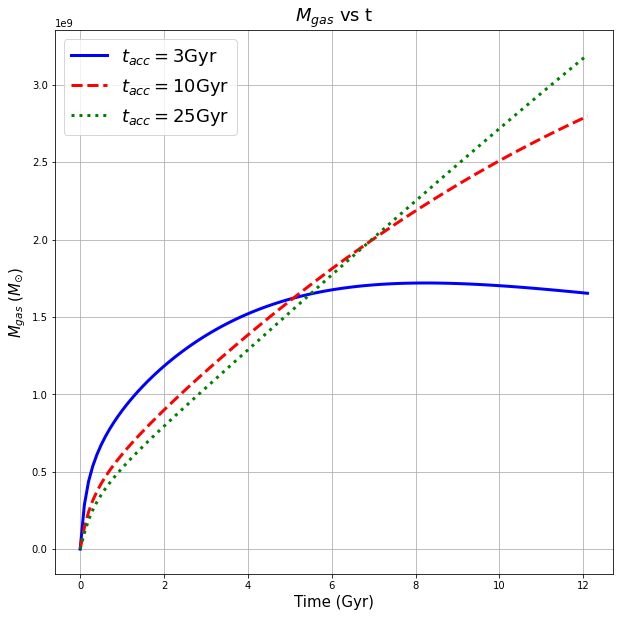

Execution time: 0.2890 seconds


In [26]:
dr = 120
integral_r = r.reshape(835,1)

if SFL_type == "old_ksl":
    Mass_gas_summed1 = 2*np.pi*spint.simpson(integral_r*Sigma_gas_old_ksl1, dx=dr, axis=0)
    Mass_gas_summed2 = 2*np.pi*spint.simpson(integral_r*Sigma_gas_old_ksl2, dx=dr, axis=0)
    Mass_gas_summed3 = 2*np.pi*spint.simpson(integral_r*Sigma_gas_old_ksl3, dx=dr, axis=0)
elif SFL_type == "new_ksl":
    Mass_gas_summed1 = 2*np.pi*spint.simpson(integral_r*Sigma_gas_new_ksl1, dx=dr, axis=0)
    Mass_gas_summed2 = 2*np.pi*spint.simpson(integral_r*Sigma_gas_new_ksl2, dx=dr, axis=0)
    Mass_gas_summed3 = 2*np.pi*spint.simpson(integral_r*Sigma_gas_new_ksl3, dx=dr, axis=0)
elif SFL_type == "boissier":
    Mass_gas_summed1 = 2*np.pi*spint.simpson(integral_r*Sigma_gas_boissier1, dx=dr, axis=0)
    Mass_gas_summed2 = 2*np.pi*spint.simpson(integral_r*Sigma_gas_boissier2, dx=dr, axis=0)
    Mass_gas_summed3 = 2*np.pi*spint.simpson(integral_r*Sigma_gas_boissier3, dx=dr, axis=0)

np.savetxt('data5/Mass_gas1_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_gas_summed1)
np.savetxt('data5/Mass_gas2_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_gas_summed2)
np.savetxt('data5/Mass_gas3_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_gas_summed3)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, Mass_gas_summed1, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, Mass_gas_summed2, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, Mass_gas_summed3, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"$M_{gas}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$M_{gas}$ $(M_{\odot})$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs6/M_gas vs time.png')

## $M_{\star}$ vs t

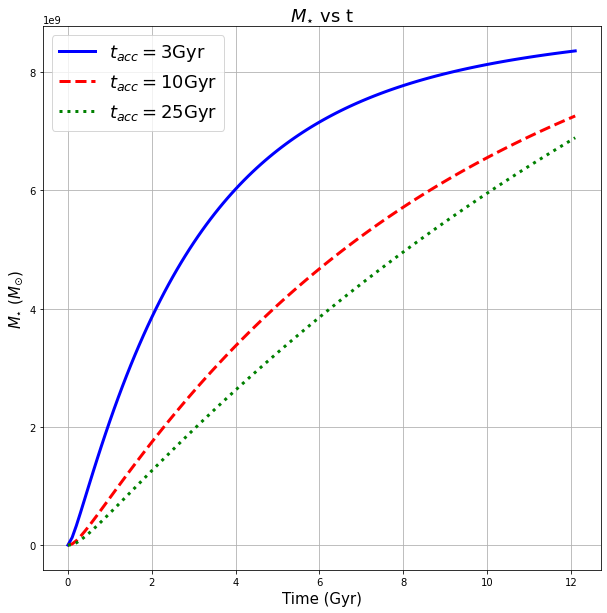

Execution time: 0.2720 seconds


In [27]:
if SFL_type == "old_ksl":
    Mass_sfr_summed1 = 2*np.pi*spint.simpson(integral_r*M_sfrs[0], dx=dr, axis=0)
    Mass_sfr_summed2 = 2*np.pi*spint.simpson(integral_r*M_sfrs[1], dx=dr, axis=0)
    Mass_sfr_summed3 = 2*np.pi*spint.simpson(integral_r*M_sfrs[2], dx=dr, axis=0)
elif SFL_type == "new_ksl":
    Mass_sfr_summed1 = 2*np.pi*spint.simpson(integral_r*M_sfrs_ksl[0], dx=dr, axis=0)
    Mass_sfr_summed2 = 2*np.pi*spint.simpson(integral_r*M_sfrs_ksl[1], dx=dr, axis=0)
    Mass_sfr_summed3 = 2*np.pi*spint.simpson(integral_r*M_sfrs_ksl[2], dx=dr, axis=0)
elif SFL_type == "boissier":
    Mass_sfr_summed1 = 2*np.pi*spint.simpson(integral_r*M_sfrs_boissier[0], dx=dr, axis=0)
    Mass_sfr_summed2 = 2*np.pi*spint.simpson(integral_r*M_sfrs_boissier[1], dx=dr, axis=0)
    Mass_sfr_summed3 = 2*np.pi*spint.simpson(integral_r*M_sfrs_boissier[2], dx=dr, axis=0)

Mass_time_star_1 = dt*np.cumsum(Mass_sfr_summed1)
Mass_time_star_2 = dt*np.cumsum(Mass_sfr_summed2)
Mass_time_star_3 = dt*np.cumsum(Mass_sfr_summed3)

np.savetxt('data5/Mass_star1_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_star_1)
np.savetxt('data5/Mass_star2_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_star_2)
np.savetxt('data5/Mass_star3_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_star_3)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, Mass_time_star_1, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, Mass_time_star_2, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, Mass_time_star_3, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"$M_{\star}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$M_{\star}$ $(M_{\odot})$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs6/M_star vs time.png')

## $M_{bar}$ vs t

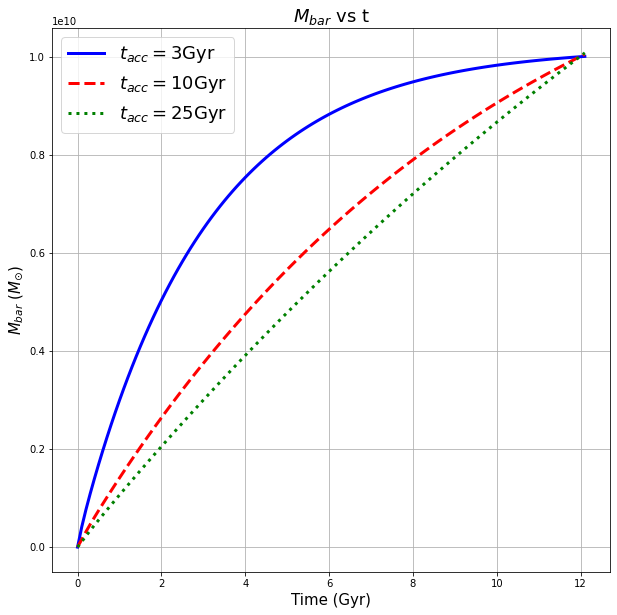

Execution time: 0.3896 seconds


In [28]:
Mass_time_bar_1 = [np.sum(x) for x in zip(Mass_time_star_1, Mass_gas_summed1)]
Mass_time_bar_2 = [np.sum(x) for x in zip(Mass_time_star_2, Mass_gas_summed2)]
Mass_time_bar_3 = [np.sum(x) for x in zip(Mass_time_star_3, Mass_gas_summed3)]

np.savetxt('data5/Mass_bar1_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_bar_1)
np.savetxt('data5/Mass_bar2_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_bar_2)
np.savetxt('data5/Mass_bar3_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', Mass_time_bar_3)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, Mass_time_bar_1, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, Mass_time_bar_2, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, Mass_time_bar_3, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"$M_{bar}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$M_{bar}$ $(M_{\odot})$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs6/M_bar vs time.png')

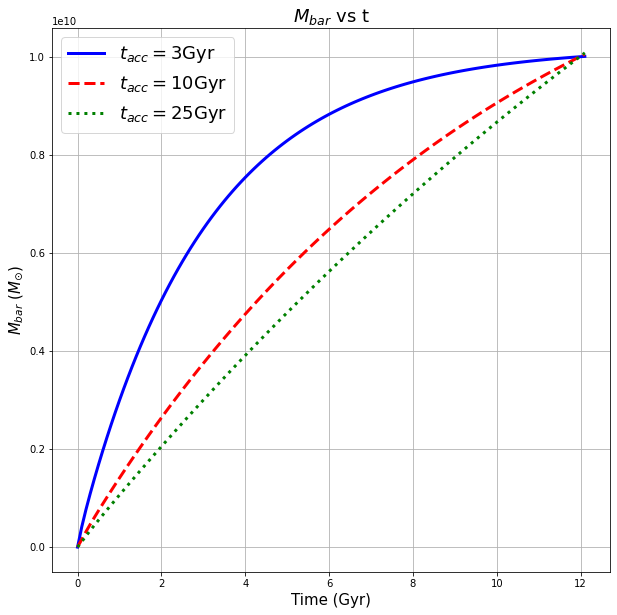

Execution time: 0.1952 seconds


In [29]:
Mass_bar_summed1 = 2*np.pi*spint.simpson(integral_r*M_bar1, dx=dr, axis=0)
Mass_bar_summed2 = 2*np.pi*spint.simpson(integral_r*M_bar2, dx=dr, axis=0)
Mass_bar_summed3 = 2*np.pi*spint.simpson(integral_r*M_bar3, dx=dr, axis=0)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, Mass_bar_summed1, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, Mass_bar_summed2, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, Mass_bar_summed3, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"$M_{bar}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$M_{bar}$ $(M_{\odot})$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()

#  Global $f_{gas}$ vs t

/var/lib/condor/execute/dir_4989/ipykernel_9828/3588487625.py:1: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas1 = np.divide(Mass_gas_summed1, Mass_time_bar_1)
/var/lib/condor/execute/dir_4989/ipykernel_9828/3588487625.py:2: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas2 = np.divide(Mass_gas_summed2, Mass_time_bar_2)
/var/lib/condor/execute/dir_4989/ipykernel_9828/3588487625.py:3: RuntimeWarning: invalid value encountered in true_divide
  f_global_gas3 = np.divide(Mass_gas_summed3, Mass_time_bar_3)


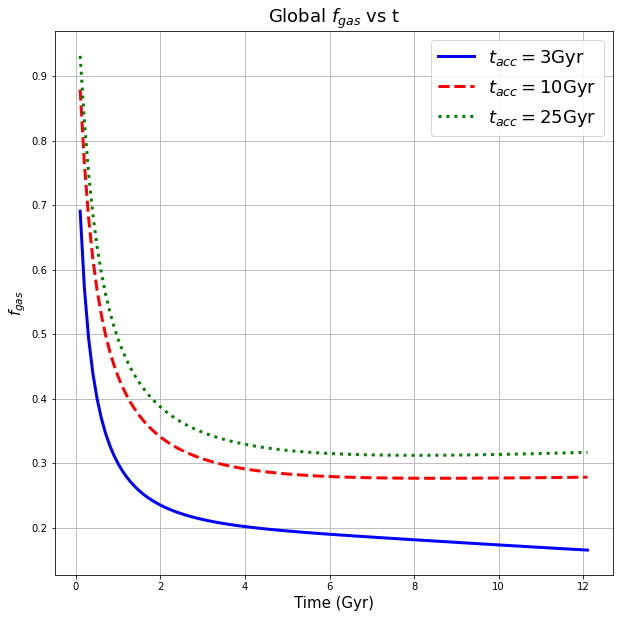

Execution time: 0.2920 seconds


In [30]:
f_global_gas1 = np.divide(Mass_gas_summed1, Mass_time_bar_1)
f_global_gas2 = np.divide(Mass_gas_summed2, Mass_time_bar_2)
f_global_gas3 = np.divide(Mass_gas_summed3, Mass_time_bar_3)

np.savetxt('data5/f_gas1_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', f_global_gas1)
np.savetxt('data5/f_gas2_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', f_global_gas2)
np.savetxt('data5/f_gas3_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', f_global_gas3)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, f_global_gas1, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, f_global_gas2, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, f_global_gas3, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"Global $f_{gas}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$f_{gas}$", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs6/Global f_gas vs time.png')

# Specific Angular Momentum $j_{bar}$

/var/lib/condor/execute/dir_4989/ipykernel_9828/539303323.py:34: RuntimeWarning: invalid value encountered in true_divide
  j_bar1 = np.divide(Nominator_bar1, Mass_time_bar_1)
/var/lib/condor/execute/dir_4989/ipykernel_9828/539303323.py:35: RuntimeWarning: invalid value encountered in true_divide
  j_bar2 = np.divide(Nominator_bar2, Mass_time_bar_2)
/var/lib/condor/execute/dir_4989/ipykernel_9828/539303323.py:36: RuntimeWarning: invalid value encountered in true_divide
  j_bar3 = np.divide(Nominator_bar3, Mass_time_bar_3)


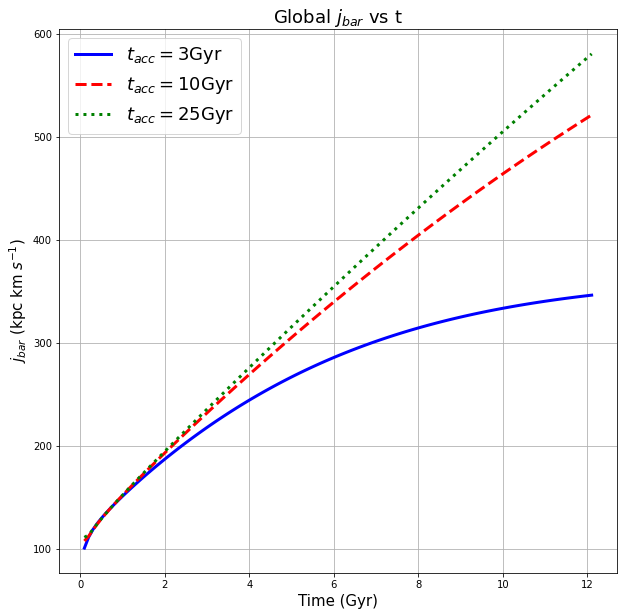

Execution time: 0.4105 seconds


In [31]:
if SFL_type == "old_ksl":
    Nominator_gas1 = 2*np.pi*spint.simpson(integral_r**2*Sigma_gas_old_ksl1*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    Nominator_gas2 = 2*np.pi*spint.simpson(integral_r**2*Sigma_gas_old_ksl2*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    Nominator_gas3 = 2*np.pi*spint.simpson(integral_r**2*Sigma_gas_old_ksl3*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)

    sfr_r_squared1 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs[0]*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    sfr_r_squared2 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs[1]*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    sfr_r_squared3 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs[2]*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
elif SFL_type == "new_ksl":
    Nominator_gas1 = 2*np.pi*spint.simpson(integral_r**2*Sigma_gas_new_ksl1*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    Nominator_gas2 = 2*np.pi*spint.simpson(integral_r**2*Sigma_gas_new_ksl2*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    Nominator_gas3 = 2*np.pi*spint.simpson(integral_r**2*Sigma_gas_new_ksl3*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)

    sfr_r_squared1 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs_ksl[0]*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    sfr_r_squared2 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs_ksl[1]*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    sfr_r_squared3 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs_ksl[2]*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
elif SFL_type == "boissier":
    Nominator_gas1 = 2*np.pi*spint.simpson(integral_r**2*Sigma_gas_boissier1*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    Nominator_gas2 = 2*np.pi*spint.simpson(integral_r**2*Sigma_gas_boissier2*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    Nominator_gas3 = 2*np.pi*spint.simpson(integral_r**2*Sigma_gas_boissier3*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)

    sfr_r_squared1 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs_boissier[0]*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    sfr_r_squared2 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs_boissier[1]*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)
    sfr_r_squared3 = 2*np.pi*spint.simpson(integral_r**2*M_sfrs_boissier[2]*exp_vrot(integral_r, M_bar_t0), dx=dr, axis=0)

Nominator_star1 = dt*np.cumsum(sfr_r_squared1)
Nominator_star2 = dt*np.cumsum(sfr_r_squared2)
Nominator_star3 = dt*np.cumsum(sfr_r_squared3)

Nominator_bar1 = [np.sum(x) for x in zip(Nominator_star1, Nominator_gas1)]
Nominator_bar2 = [np.sum(x) for x in zip(Nominator_star2, Nominator_gas2)]
Nominator_bar3 = [np.sum(x) for x in zip(Nominator_star3, Nominator_gas3)]

j_bar1 = np.divide(Nominator_bar1, Mass_time_bar_1)
j_bar2 = np.divide(Nominator_bar2, Mass_time_bar_2)
j_bar3 = np.divide(Nominator_bar3, Mass_time_bar_3)

np.savetxt('data5/j_bar1_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', j_bar1)
np.savetxt('data5/j_bar2_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', j_bar2)
np.savetxt('data5/j_bar3_vs_t_'+f'{np.log10(M_bar_t0)}'+'.txt', j_bar3)

fig = figure(figsize=(10,10), facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, j_bar1/1000, label=r"$t_{acc} = 3$Gyr", color="blue", lw=3)
frame.plot(M_times1, j_bar2/1000, label=r"$t_{acc} = 10$Gyr", linestyle="dashed", color="red", lw=3)
frame.plot(M_times1, j_bar3/1000, label=r"$t_{acc} = 25$Gyr", linestyle="dotted", color="green", lw=3)
frame.set_title(r"Global $j_{bar}$ vs t", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$j_{bar}$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs6/Global j_bar vs time.png')

# Model Definer

In [38]:
def Full_final_definer(Mbar, t_acc_arr, star_formation_law, res=120, Rmax=100.1, at_t0=True, ns=1, ks=1):
    """
    Defines the global fraction of gas and baryonic specific angular momentum arrays.
    This function is self-contained; together with the Sigma_definer function, and the functions defining 
    the accretion radius and angular momentum, as well as the baryonic mass and rotational velocity, it 
    alone should give the arrays for the final FINAL graph.
    
    --------------
    Inputs:
        - Mbar (float)           --> Baryonic mass value for which you want to evaluate global gas fraction and 
                                     (specific) angular momentum.
        - t_acc_arr (np.array)   --> Array containing the accretion timescale values. This function now works 
                                     for any number of values within the array!
        - res (float)            --> (optional) Resolution of the radius array; gives the values of the radii at
                                     which values are evaluated. Default is 120 pc.
        - Rmax (float)           --> (optional) Maximum radius to evaluate. Default is 100.1 kpc. Together with
                                     res these defaults were chosen as to optimize run time and convergence of 
                                     specific angular momentum. 
        - at_t0 (bool)           --> (optional) Specifes whether to return just the values today (True), or the 
                                     entire evolution (False). Default is True.
        - ns (float)             --> (optional) Power parameter of the accreting angular momentum form. 
                                     Default is 1.
        - ks (float)             --> (optional) Slope parameter of the accreting angular momentum form. 
                                     Default is 1.
    
    Returns:
        - f_gas_array (np.array) --> Array containing, depending on at_t0, either the values of the global
                                     gas fraction today (t = 12Gyr), or in the entire evolution.
        - j_bar_array (np.array) --> Array containing, depending on at_t0, either the values of the specific
                                     angular momentum today (t = 12Gyr), or in the entire evolution.
    
    """
    
    r = np.arange(0,1000*Rmax,res)
    dr = res
    
    SD_gas = np.array([Sigma_definer(r, t_acc, Mbar, SFL_type=star_formation_law, n=ns, con=ks) for t_acc in t_acc_arr])
    SD_sfr = np.array([SFL(sigma=SD_gas[i], sfl_type=star_formation_law, R=r, Mbar=Mbar) for i in range(len(SD_gas))])
    
    r = r.reshape(len(r),1)
    
    M_gas = np.array([2*np.pi*spint.simpson(r*SD_gas[i], dx=dr, axis=0) for i in range(len(SD_gas))])
    M_sfr = np.array([2*np.pi*spint.simpson(r*SD_sfr[i], dx=dr, axis=0) for i in range(len(SD_gas))])
    M_star = np.array([dt*np.cumsum(M_sfr[i]) for i in range(len(SD_gas))])
    M_bar = np.array([np.array([np.sum(x) for x in zip(M_star[i], M_gas[i])]) for i in range(len(SD_gas))])
    f_gas_global = np.array([np.divide(M_gas[i], M_bar[i]) for i in range(len(SD_gas))])

    #Mbar_allsame = np.full(len(M_bar[0]), M_bar[0][-1])
    #v_rot = v_btfr_def(Mbar_allsame[0])
    rv = rv_def(Mbar)
    
    nominator_gas = np.array([2*np.pi*spint.simpson(r**2*SD_gas[i]*exp_vrot(r, Mbar), dx=dr, axis=0) for i in range(len(SD_gas))])
    nominator_sfr = np.array([2*np.pi*spint.simpson(r**2*SD_sfr[i]*exp_vrot(r, Mbar), dx=dr, axis=0) for i in range(len(SD_gas))])
    nominator_star = np.array([dt*np.cumsum(nominator_sfr[i]) for i in range(len(SD_gas))])
    nominator_bar = np.array([np.array([np.sum(x) for x in zip(nominator_star[i], nominator_gas[i])]) for i in range(len(SD_gas))])
    j_bar = np.array([np.divide(nominator_bar[i], M_bar[i]) for i in range(len(SD_gas))])
    
    if (at_t0==True):
        f_gas_array = f_gas_global[:,-1]
        j_bar_array = j_bar[:,-1]/1000
    else:
        f_gas_array = f_gas_global
        j_bar_array = j_bar/1000
    return f_gas_array, j_bar_array

#This defines everything for real, and better :)


Execution time: 0.0157 seconds


## Different $\omega_{acc}$

In [39]:
t_acc_array_ext = np.array([1,3,10,25,-25,-10,-3,-1])
try_f_gas, try_j_bar = Full_final_definer(10**10, t_acc_array_ext, star_formation_law="old_ksl", at_t0=False)
#j_accr = j_acc_def(j_maxer(10**10), 10**10, M_times1, n=1, con=1)

/var/lib/condor/execute/dir_4989/ipykernel_9828/2322890892.py:6: RuntimeWarning: invalid value encountered in power
  return (1-Rf)*A*(sigma**N)


Execution time: 359.0523 seconds


/var/lib/condor/execute/dir_4989/ipykernel_9828/2233009271.py:46: RuntimeWarning: invalid value encountered in true_divide
  f_gas_global = np.array([np.divide(M_gas[i], M_bar[i]) for i in range(len(SD_gas))])
/var/lib/condor/execute/dir_4989/ipykernel_9828/2233009271.py:56: RuntimeWarning: invalid value encountered in true_divide
  j_bar = np.array([np.divide(nominator_bar[i], M_bar[i]) for i in range(len(SD_gas))])


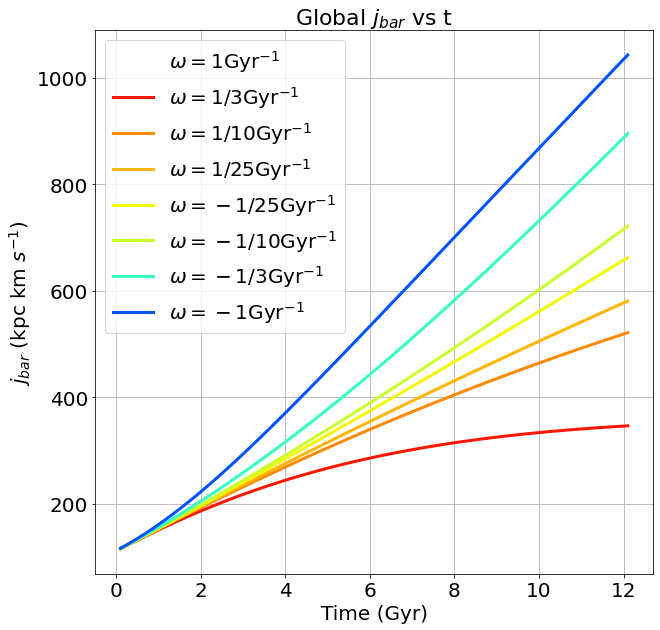

Execution time: 0.3258 seconds


In [40]:
cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")

fig = figure(figsize=(10,10),  facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, try_j_bar[0], label=r"$\omega = 1$Gyr$^{-1}$", color=cmap(try_f_gas[0][-1]), lw=3)
frame.plot(M_times1, try_j_bar[1], label=r"$\omega = 1/3$Gyr$^{-1}$", color=cmap(try_f_gas[1][-1]), lw=3)
frame.plot(M_times1, try_j_bar[2], label=r"$\omega = 1/10$Gyr$^{-1}$", color=cmap(try_f_gas[2][-1]), lw=3)
frame.plot(M_times1, try_j_bar[3], label=r"$\omega = 1/25$Gyr$^{-1}$", color=cmap(try_f_gas[3][-1]), lw=3)
frame.plot(M_times1, try_j_bar[4], label=r"$\omega = -1/25$Gyr$^{-1}$", color=cmap(try_f_gas[4][-1]), lw=3)
frame.plot(M_times1, try_j_bar[5], label=r"$\omega = -1/10$Gyr$^{-1}$", color=cmap(try_f_gas[5][-1]), lw=3)
frame.plot(M_times1, try_j_bar[6], label=r"$\omega = -1/3$Gyr$^{-1}$", color=cmap(try_f_gas[6][-1]), lw=3)
frame.plot(M_times1, try_j_bar[7], label=r"$\omega = -1$Gyr$^{-1}$", color=cmap(try_f_gas[7][-1]), lw=3)
frame.set_title(r"Global $j_{bar}$ vs t", fontsize = 22)
frame.set_xlabel("Time (Gyr)", fontsize = 20)
frame.set_ylabel(r"$j_{bar}$ (kpc km $s^{-1}$)", fontsize = 20)
frame.tick_params(axis="both", labelsize=20)
frame.legend(prop={'size': 20})
frame.grid()
show()

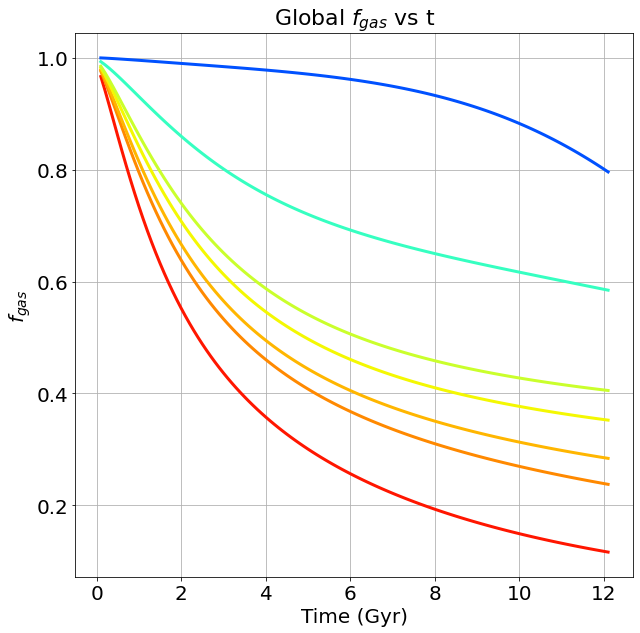

Execution time: 0.1461 seconds


In [41]:
fig = figure(figsize=(10,10),  facecolor='w')
frame = fig.add_subplot(1,1,1)
frame.plot(M_times1, try_f_gas[0], label=r"$\omega = 1$Gyr$^{-1}$", color=cmap(try_f_gas[0][-1]), lw=3)
frame.plot(M_times1, try_f_gas[1], label=r"$\omega = 1/3$Gyr$^{-1}$", color=cmap(try_f_gas[1][-1]), lw=3)
frame.plot(M_times1, try_f_gas[2], label=r"$\omega = 1/10$Gyr$^{-1}$", color=cmap(try_f_gas[2][-1]), lw=3)
frame.plot(M_times1, try_f_gas[3], label=r"$\omega = 1/25$Gyr$^{-1}$", color=cmap(try_f_gas[3][-1]), lw=3)
frame.plot(M_times1, try_f_gas[4], label=r"$\omega = -1/25$Gyr$^{-1}$", color=cmap(try_f_gas[4][-1]), lw=3)
frame.plot(M_times1, try_f_gas[5], label=r"$\omega = -1/10$Gyr$^{-1}$", color=cmap(try_f_gas[5][-1]), lw=3)
frame.plot(M_times1, try_f_gas[6], label=r"$\omega = -1/3$Gyr$^{-1}$", color=cmap(try_f_gas[6][-1]), lw=3)
frame.plot(M_times1, try_f_gas[7], label=r"$\omega = -1$Gyr$^{-1}$", color=cmap(try_f_gas[7][-1]), lw=3)
frame.set_title(r"Global $f_{gas}$ vs t", fontsize = 22)
frame.set_xlabel("Time (Gyr)", fontsize = 20)
frame.set_ylabel(r"$f_{gas}$", fontsize = 20)
frame.tick_params(axis="both", labelsize=20)
#frame.legend(prop={'size': 20})
frame.grid()
show()

## $\dot{M}_{acc}$ vs t

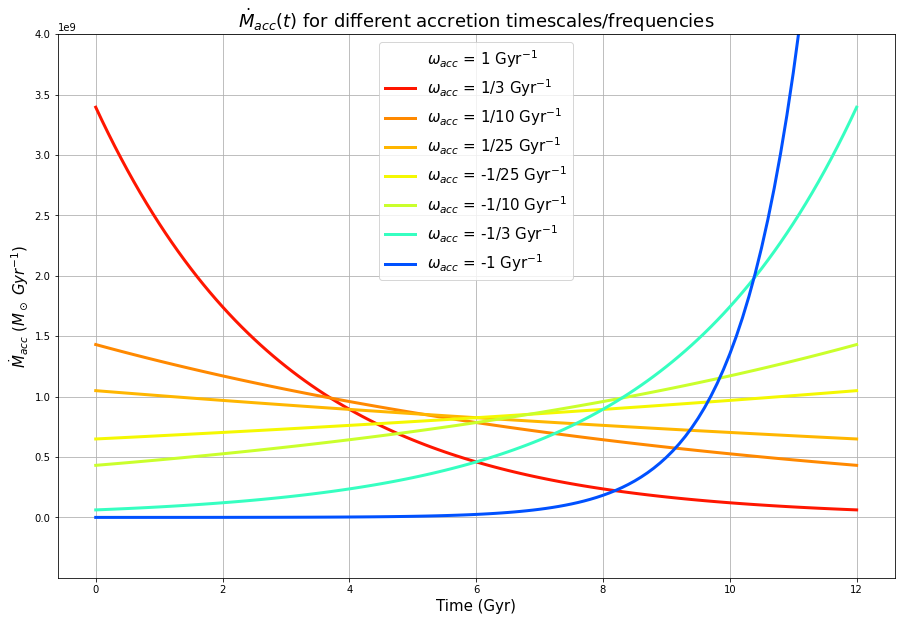

Execution time: 0.6768 seconds


In [42]:
def M_acc_dot_def(M_bar, t, t_acc):
    return C_def(M_bar, t_acc)*np.exp(-t/t_acc)

t_acc_array_ext = np.array([1,3,10,25,-25,-10,-3,-1])

fig = figure(figsize=(15,10),  facecolor='w')
frame = fig.add_subplot(1,1,1)
for i in range(len(t_acc_array_ext)):
    frame.plot(M_times, M_acc_dot_def(10**10, M_times, t_acc_array_ext[i]), label=r"$\omega_{acc}$ = "+f"{Fraction(1,t_acc_array_ext[i])}"+r" Gyr$^{-1}$", color=cmap(try_f_gas[i][-1]), lw=3)
frame.set_title(r"$\dot{M}_{acc}(t)$ for different accretion timescales/frequencies", fontsize = 18)
frame.set_xlabel("Time (Gyr)", fontsize = 15)
frame.set_ylabel(r"$\dot{M}_{acc}$ $(M_\odot\ Gyr^{-1})$", fontsize = 15)
frame.set_ylim(ymax=0.4e10)
frame.legend(prop={'size': 15})
frame.grid()
show()
fig.savefig('graphs6/M_acc_dot vs t (n=1,k=1)'+f'_{np.log10(M_bar_t0)}'+'.png')

In [43]:
for i in range(len(try_f_gas)):
    print(try_f_gas[i][-1])

nan
0.11651908937055916
0.2376063004684639
0.28402105126463056
0.3523276023520624
0.4053081637800891
0.5845251903977466
0.7958461616905137
Execution time: 0.0013 seconds


## Testing (8 $t_{acc}$ and 4 $M_{bar}$)

In [36]:
log_M_bar_array = np.array([8,9,10,11])
t_acc_array = np.array([1,3,10,25,-25,-10,-3,-1])
f_gas_array_4_8 = np.zeros((len(log_M_bar_array),len(t_acc_array)))
j_bar_array_4_8 = np.zeros((len(log_M_bar_array),len(t_acc_array)))

for i,M in enumerate(log_M_bar_array):
    f_gas_temp, j_bar_temp = Full_final_definer(10**M, t_acc_array, star_formation_law="new_ksl", ns=1, ks=1)
    f_gas_array_4_8[i] = f_gas_temp
    j_bar_array_4_8[i] = j_bar_temp

/var/lib/condor/execute/dir_140973/ipykernel_141843/2322890892.py:10: RuntimeWarning: invalid value encountered in power
  return (1-Rf)*A_ksl*(sigma**N_ksl)


KeyboardInterrupt: 

In [ ]:
log_j_bar_array_4_8 = np.log10(j_bar_array_4_8)

cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe1 = divider.append_axes("right", size="5%", pad=0.15)
for x, y, z in zip(log_M_bar_array, log_j_bar_array_4_8, f_gas_array_4_8):
    gg = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=100)
gg.set_label("Model")
cbar1 = fig.colorbar(gg, cax=colbarframe1)
cbar1.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

frame.plot(np.linspace(8,11.5,50), np.log10(j_maxer(10**np.linspace(8,11.5,50))), color='k', lw=3.5, linestyle='dashed', alpha=0.6, label=r"$j_{max}$")

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
#frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()

In [ ]:
f_gas_array_4_8

## Final Plot (10 $t_{acc}$ and 50 $M_{bar}$)

In [ ]:
log_M_bar_array = np.linspace(8,11.5,50)
t_acc_array = np.array([1,2,3,10,25,-25,-10,-3,-2,-1])
f_gas_array_10_50 = np.zeros((len(log_M_bar_array),len(t_acc_array)))
j_bar_array_10_50 = np.zeros((len(log_M_bar_array),len(t_acc_array)))

for i,M in enumerate(log_M_bar_array):
    f_gas_temp, j_bar_temp = Full_final_definer(10**M, t_acc_array, star_formation_law="new_ksl", ns=1, ks=1)
    f_gas_array_10_50[i] = f_gas_temp
    j_bar_array_10_50[i] = j_bar_temp
    
np.savetxt('data5/final_f_gas.txt', f_gas_array_10_50)
np.savetxt('data5/final_j_bar.txt', j_bar_array_10_50)

### Plot

In [ ]:
f_gas_array_10_50 = np.loadtxt('data5/final_f_gas.txt')
j_bar_array_10_50 = np.loadtxt('data5/final_j_bar.txt')
log_M_bar_array = np.linspace(8,11.5,50)
t_acc_array = np.array([1,2,3,10,25,-25,-10,-3,-2,-1])

log_f_gas_array_10_50 = np.log10(f_gas_array_10_50)
log_j_bar_array_10_50 = np.log10(j_bar_array_10_50)

cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10),  facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe1 = divider.append_axes("right", size="5%", pad=0.15)
for x, y, z in zip(log_M_bar_array, log_j_bar_array_10_50, f_gas_array_10_50):
    mod = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=50)
mod.set_label("Model")
cbar1 = fig.colorbar(mod, cax=colbarframe1)
cbar1.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs6/log j_bar vs log_M_bar with Pavel (50 masses).png')

# Interpolate at constant $M_{bar}$

In [ ]:
cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe = divider.append_axes("right", size="5%", pad=0.15)

n=1000
interp_f_gas_array_10_50 = np.zeros((len(log_M_bar_array),n))
for i,Mbar in enumerate(log_M_bar_array):
    interp_f_gas_array_10_50[i] = np.linspace(f_gas_array_10_50[i].min(),f_gas_array_10_50[i].max(),n)
    
interp_j_bar_array_10_50 = np.zeros((len(log_M_bar_array),n))
for i,Mbar in enumerate(log_M_bar_array):
    ipl_10_50 = spl.InterpolatedUnivariateSpline(f_gas_array_10_50[i], log_j_bar_array_10_50[i], k=1)
    interp_j_bar_array_10_50[i] = ipl_10_50(interp_f_gas_array_10_50[i])

for x, y, z in zip(log_M_bar_array, interp_j_bar_array_10_50, interp_f_gas_array_10_50):
    mod = frame.scatter([x]*len(y), y, facecolors=cmap(z), s=30)
mod.set_label("Model")
cbar = fig.colorbar(mod, cax=colbarframe)
cbar.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

#Data
frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="^", facecolors=cmap(BARY['fgas']), s=50, alpha=0.8)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 18})
frame.grid()
show()
fig.savefig('graphs6/log j_bar vs log_M_bar with Pavel.png')

# Interpolator

In [ ]:
def modelled_j_bar2(f_gas_array, j_bar_array, f_gas_value, kind=1):
    """
    The function takes as input the arrays for f_gas and j_bar (possibly already interpolated), 
    together with a wanted value of f_gas for which to slice out the 1D array. 
    
    ------------
    Inputs:
    - f_gas_array = interpolated 2D array of f_gas
    - j_bar_array = interpolated 2D array of j_bar
    - f_gas_value = value of f_gas for which to slice the f_gas/j_bar arrays
    - kind = Inerpolation type (default is 1 - linear)
    
    The function does the following
    - Creates a list 'index_array', which has the indexes of constant f_gas_value chosen as elements.
    - Then, it iteratively takes from the j_bar_array the values corresponding to the indexes from index_array
    - Finally it interpolates the indexed j_bar_array through the M_bar_array, to get a plottable linear function.
    
    Returns:
    - indexed_M_array_lin = A simple linspace with the initial and final values of the original log_M_bar_array
    """
    indexed_j_array = []
    index_array = []
    true_list = []
    
    for i in range(len(log_M_bar_array)):
        if f_gas_value>np.min(f_gas_array[i]) and f_gas_value<np.max(f_gas_array[i]):
            index_array.append(np.argwhere(f_gas_array[i] == min(f_gas_array[i], key=lambda x:abs(x-f_gas_value))))
            true_list.append(1)
        else:
            index_array.append(0)
            true_list.append(0)
    
    j = 0
    while (j<50):
        if (true_list[j]==1):
            indexed_j_array.append(j_bar_array[j][index_array[j]])
        j += 1
    
    if len(indexed_j_array)>kind:
        index = np.argwhere(np.array(true_list) == 1)
        indexed_M_array = log_M_bar_array[index]
        indexed_M_array_lin = np.linspace(indexed_M_array[0], indexed_M_array[-1], 1000)
        interpolation = spl.InterpolatedUnivariateSpline(indexed_M_array.reshape(len(indexed_M_array),), indexed_j_array, k=kind)
        interpolated_j_array = interpolation(indexed_M_array_lin).reshape(len(indexed_M_array_lin),)
    else:
        indexed_M_array_lin = []
        interpolated_j_array = []
    
    return indexed_M_array_lin, interpolated_j_array

# Final Graph -- interpolation at constant $f_{gas}$

In [ ]:
cmap = cm.jet_r
mpl.rc("image", cmap="jet_r")
fig = figure(figsize=(15,10), facecolor='w')
frame = fig.add_subplot(1,1,1)

#Model
divider = make_axes_locatable(frame)
colbarframe = divider.append_axes("right", size="5%", pad=0.15)

frame.plot([], [], ' ', label="Models")

f_gas_values = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cmap(f_gas_values)
for i,f_gas_value in enumerate(f_gas_values):
    indexed_M_array_lin, indexed_j_array = modelled_j_bar2(interp_f_gas_array_10_50, interp_j_bar_array_10_50, f_gas_value)
    ax1 = frame.plot(indexed_M_array_lin, indexed_j_array, label=r"$f_{gas} = $"+f"{f_gas_value:.2f}", color=colors[i], lw=3.5, zorder=2)

#frame.plot(log_M_bar_array, np.log10(j_maxer(10**log_M_bar_array)), color='k', lw=3.5, linestyle='dashed', alpha=0.6, label=r"$j_{max}$")

#Data
ax2 = frame.scatter(obs_Mbar, obs_jbar, label="Obs data", marker="o", facecolors=cmap(BARY['fgas']), edgecolors="grey", s=100, zorder=3)
frame.errorbar(obs_Mbar, obs_jbar, xerr=obs_Mbar_errors, yerr=obs_jbar_errors, fmt = ' ', ecolor = 'grey', capsize = 3, alpha=0.3, zorder=0)
cbar = fig.colorbar(ax2, cax=colbarframe)
cbar.set_label(r"$f_{gas}$", rotation=270, fontsize=15)

frame.set_title(r"$log(j_{bar})$ vs $log(M_{bar})$ for $n=1$, $k=1$", fontsize = 18)
frame.set_xlabel(r"$log(M_{bar})$ $(M_{\odot})$", fontsize = 15)
frame.set_ylabel(r"$log(j_{bar})$ (kpc km $s^{-1}$)", fontsize = 15)
frame.legend(prop={'size': 15})
frame.grid(zorder=1)
show()
fig.savefig('graphs6/log j_bar vs log_M_bar with Pavel (interpolated).png')